In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install optuna==0.18.1

     |████████████████████████████████| 122kB 7.5MB/s 
     |████████████████████████████████| 1.1MB 12.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 112kB 24.3MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=37b5d9063693f81d322a8187fd4f1c33d67e41cdad944013cd280bb53e5908af
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-0.18.1-cp36-none-any.whl size=165106 sha256=f9c3f46a8dbbbc9563216f573965cd5b2bdeaad8f82d608b992379f28e0bf019
  Stored in directory: /root/.cache/pip/wheels/40

In [0]:
import os
print( '변경 전 기본 경로 :' )
print(  os.getcwd() )
os.chdir('./drive/My Drive/데이콘_게임데이터분석')
print( '변경 후 파일 경로 :' )
print(  os.getcwd()  )


import optuna                               # 베이지안 최적화 라이브러리  
from optuna import Trial
import gc
debug = False
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook              # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore")           # 경고 문구 미표시
%time
train16 = pd.read_pickle('train16.pkl')

%time
test16 = pd.read_pickle('test16.pkl')

변경 전 기본 경로 :
/content
변경 후 파일 경로 :
/content/drive/My Drive/데이콘_게임데이터분석
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


## 루트변환 or 로그변환후 생성하기, 종족 변수 인코딩

## Train Set diff생성 (apply 적용)

In [0]:
######################################### 종족 인코딩하기 ########################################
def spec_convert(x):
    if x[0] == 'Z':
        return 2
    elif x[0] == 'P':
        return 1
    else:
        return 0

train16['P0_species']=train16.apply(lambda x: spec_convert(x['P0_species']),axis=1)
train16['P1_species']=train16.apply(lambda x: spec_convert(x['P1_species']),axis=1)

################################ 결측치가 있는 column & 사용 안할 column들 제거해놓기 ######################
no_missing_train0 = train16.drop(['player0_starting_category','player1_starting_category','player0_center_x','player0_center_y','player1_center_x','player1_center_y',]
                                , axis=1)

################################## 종족이라는 변수는 빼고 P0와 P1간의 차이를 구할 거기 때문에 ##########################
columns = pd.Series(no_missing_train0.columns)
columns.index = no_missing_train0.columns.tolist()
columns = columns.drop(['P0_species','P1_species','map'])
columns = columns.tolist()

#################### 범주형 변수들 ################# (종족은 순서형으로 봐야될지도 확인ㄱㄱㄱ)
cat_features = ['P0_species','P1_species','map']

####################### P0를 포함하는 컬럼, P1을 포함하는 컬럼 #################################
p0_columns = [c for c in columns if c.startswith('P0_')]
p1_columns = [c for c in columns if c.startswith('P1_')]

####################################### diff변수 생성 전에 루트변환? (카운팅은 높을수록 서로간의 차이가 의미가 없으므로) ##############################
from math import log
from math import sqrt
import re
diff_feat_list = []

for rawfeat0, rawfeat1 in zip(p0_columns,p1_columns):
  #no_missing_train0[rawfeat0]  =  no_missing_train0.apply(lambda x: sqrt(x[rawfeat0]),axis=1) 
  #no_missing_train0[rawfeat1]  =  no_missing_train0.apply(lambda x: sqrt(x[rawfeat1]),axis=1) 
  diff_feat = 'diff_'+ re.sub('P0_','', rawfeat0)
  diff_feat_list.append(diff_feat)
  no_missing_train0[diff_feat]  =  no_missing_train0.apply(lambda x: (x[rawfeat1]-x[rawfeat0]), axis=1)

################################# diff 변수 생성 후 본래 P0, P1 컬럼 없애기 #######################

#no_missing_train0 = no_missing_train0.drop(p0_columns+p1_columns,axis=1)

no_missing_train0.describe()


,P0_Ability_bytime_0,P0_Ability_bytime_2,P0_Ability_bytime_4,P0_Ability_bytime_6,P0_Ability_bytime_8,P0_Ability_bytime_10,P0_AddToControlGroup_bytime_0,P0_AddToControlGroup_bytime_2,P0_AddToControlGroup_bytime_4,P0_AddToControlGroup_bytime_6,P0_AddToControlGroup_bytime_8,P0_AddToControlGroup_bytime_10,P0_Camera_bytime_0,P0_Camera_bytime_2,P0_Camera_bytime_4,P0_Camera_bytime_6,P0_Camera_bytime_8,P0_Camera_bytime_10,P0_ControlGroup_bytime_0,P0_ControlGroup_bytime_2,P0_ControlGroup_bytime_4,P0_ControlGroup_bytime_6,P0_ControlGroup_bytime_8,P0_ControlGroup_bytime_10,P0_GetControlGroup_bytime_0,P0_GetControlGroup_bytime_2,P0_GetControlGroup_bytime_4,P0_GetControlGroup_bytime_6,P0_GetControlGroup_bytime_8,P0_GetControlGroup_bytime_10,P0_Right Click_bytime_0,P0_Right Click_bytime_2,P0_Right Click_bytime_4,P0_Right Click_bytime_6,P0_Right Click_bytime_8,P0_Right Click_bytime_10,P0_Selection_bytime_0,P0_Selection_bytime_2,P0_Selection_bytime_4,P0_Selection_bytime_6,...,diff_Click_Resources_bytime_4,diff_Click_Resources_bytime_6,diff_Click_Resources_bytime_8,diff_Click_Resources_bytime_10,diff_Click_DSC_bytime_0,diff_Click_DSC_bytime_2,diff_Click_DSC_bytime_4,diff_Click_DSC_bytime_6,diff_Click_DSC_bytime_8,diff_Click_DSC_bytime_10,diff_Click_DSG_bytime_0,diff_Click_DSG_bytime_2,diff_Click_DSG_bytime_4,diff_Click_DSG_bytime_6,diff_Click_DSG_bytime_8,diff_Click_DSG_bytime_10,diff_Click_DSF_bytime_0,diff_Click_DSF_bytime_2,diff_Click_DSF_bytime_4,diff_Click_DSF_bytime_6,diff_Click_DSF_bytime_8,diff_Click_DSF_bytime_10,diff_Click_COB_bytime_0,diff_Click_COB_bytime_2,diff_Click_COB_bytime_4,diff_Click_COB_bytime_6,diff_Click_COB_bytime_8,diff_Click_COB_bytime_10,diff_Click_Gas_bytime_0,diff_Click_Gas_bytime_2,diff_Click_Gas_bytime_4,diff_Click_Gas_bytime_6,diff_Click_Gas_bytime_8,diff_Click_Gas_bytime_10,diff_Click_Multi_bytime_0,diff_Click_Multi_bytime_2,diff_Click_Multi_bytime_4,diff_Click_Multi_bytime_6,diff_Click_Multi_bytime_8,diff_Click_Multi_bytime_10
count,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,...,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000
mean,7.431467,18.142236,30.575427,41.003627,48.476178,48.806467,0.457502,0.881251,1.297361,1.643934,1.904996,1.918450,79.440214,179.542781,273.952794,349.860774,404.903530,407.357918,0.116948,0.203437,0.286324,0.351358,0.393908,0.396275,43.751595,80.108690,103.278787,119.119855,129.067735,129.523307,29.220416,64.809066,99.850587,128.037868,148.046975,148.942118,31.815265,59.001441,84.699681,106.646404,...,-0.177634,-0.173570,-0.168733,-0.167550,-0.076070,-0.090193,-0.085897,-0.085537,-0.087647,-0.085897,-0.002444,-0.000412,-0.000463,-0.000180,0.000077,0.000077,0.000309,-0.005968,-0.004193,-0.002727,-0.005402,-0.005377,-0.000720,-0.001055,-0.001106,-0.001363,-0.000900,-0.001080,0.000412,-0.026497,-0.013069,-0.015127,-0.025777,-0.023950,-0.001132,-0.012014,-0.017313,-0.023282,-0.037533,-0.038537
std,2.544722,6.314469,13.162384,20.721461,27.707051,28.119083,0.937607,1.435750,2.003790,2.540955,3.009919,3.038626,46.618459,86.199005,128.840126,175.399127,219.76264

## Test Set diff생성 (apply 적용)

In [0]:


test16['P0_species']=test16.apply(lambda x: spec_convert(x['P0_species']),axis=1)
test16['P1_species']=test16.apply(lambda x: spec_convert(x['P1_species']),axis=1)

################################ 결측치가 있는 column & 사용 안할 column들 제거해놓기 ######################
no_missing_test = test16.drop(['player0_starting_category','player1_starting_category','player0_center_x','player0_center_y','player1_center_x','player1_center_y',]
                                , axis=1)

################################## 종족이라는 변수는 빼고 P0와 P1간의 차이를 구할 거기 때문에 ##########################
columns = pd.Series(no_missing_test.columns)
columns.index = no_missing_test.columns.tolist()
columns = columns.drop(['P0_species','P1_species','map'])
columns = columns.tolist()

#################### 범주형 변수들 ################# (종족은 순서형으로 봐야될지도 확인ㄱㄱㄱ)
cat_features = ['P0_species','P1_species','map']

####################### P0를 포함하는 컬럼, P1을 포함하는 컬럼 #################################
p0_columns = [c for c in columns if c.startswith('P0_')]
p1_columns = [c for c in columns if c.startswith('P1_')]

####################################### diff변수 생성 전에 루트변환? (카운팅은 높을수록 서로간의 차이가 의미가 없으므로) ##############################
from math import log
from math import sqrt
import re
diff_feat_list = []

for rawfeat0, rawfeat1 in zip(p0_columns,p1_columns):
  #no_missing_test[rawfeat0]  =  no_missing_test.apply(lambda x: sqrt(x[rawfeat0]),axis=1) 
  #no_missing_test[rawfeat1]  =  no_missing_test.apply(lambda x: sqrt(x[rawfeat1]),axis=1) 
  diff_feat = 'diff_'+ re.sub('P0_','', rawfeat0)
  diff_feat_list.append(diff_feat)
  no_missing_test[diff_feat]  =  no_missing_test.apply(lambda x: (x[rawfeat1]-x[rawfeat0]), axis=1)

################################# diff 변수 생성 후 본래 P0, P1 컬럼 없애기 #######################

#no_missing_test = no_missing_test.drop(p0_columns+p1_columns,axis=1)

no_missing_test.describe()

,P0_Ability_bytime_0,P0_Ability_bytime_2,P0_Ability_bytime_4,P0_Ability_bytime_6,P0_Ability_bytime_8,P0_Ability_bytime_10,P0_AddToControlGroup_bytime_0,P0_AddToControlGroup_bytime_2,P0_AddToControlGroup_bytime_4,P0_AddToControlGroup_bytime_6,P0_AddToControlGroup_bytime_8,P0_AddToControlGroup_bytime_10,P0_Camera_bytime_0,P0_Camera_bytime_2,P0_Camera_bytime_4,P0_Camera_bytime_6,P0_Camera_bytime_8,P0_Camera_bytime_10,P0_ControlGroup_bytime_0,P0_ControlGroup_bytime_2,P0_ControlGroup_bytime_4,P0_ControlGroup_bytime_6,P0_ControlGroup_bytime_8,P0_ControlGroup_bytime_10,P0_GetControlGroup_bytime_0,P0_GetControlGroup_bytime_2,P0_GetControlGroup_bytime_4,P0_GetControlGroup_bytime_6,P0_GetControlGroup_bytime_8,P0_GetControlGroup_bytime_10,P0_Right Click_bytime_0,P0_Right Click_bytime_2,P0_Right Click_bytime_4,P0_Right Click_bytime_6,P0_Right Click_bytime_8,P0_Right Click_bytime_10,P0_Selection_bytime_0,P0_Selection_bytime_2,P0_Selection_bytime_4,P0_Selection_bytime_6,...,diff_Click_Resources_bytime_4,diff_Click_Resources_bytime_6,diff_Click_Resources_bytime_8,diff_Click_Resources_bytime_10,diff_Click_DSC_bytime_0,diff_Click_DSC_bytime_2,diff_Click_DSC_bytime_4,diff_Click_DSC_bytime_6,diff_Click_DSC_bytime_8,diff_Click_DSC_bytime_10,diff_Click_DSG_bytime_0,diff_Click_DSG_bytime_2,diff_Click_DSG_bytime_4,diff_Click_DSG_bytime_6,diff_Click_DSG_bytime_8,diff_Click_DSG_bytime_10,diff_Click_DSF_bytime_0,diff_Click_DSF_bytime_2,diff_Click_DSF_bytime_4,diff_Click_DSF_bytime_6,diff_Click_DSF_bytime_8,diff_Click_DSF_bytime_10,diff_Click_COB_bytime_0,diff_Click_COB_bytime_2,diff_Click_COB_bytime_4,diff_Click_COB_bytime_6,diff_Click_COB_bytime_8,diff_Click_COB_bytime_10,diff_Click_Gas_bytime_0,diff_Click_Gas_bytime_2,diff_Click_Gas_bytime_4,diff_Click_Gas_bytime_6,diff_Click_Gas_bytime_8,diff_Click_Gas_bytime_10,diff_Click_Multi_bytime_0,diff_Click_Multi_bytime_2,diff_Click_Multi_bytime_4,diff_Click_Multi_bytime_6,diff_Click_Multi_bytime_8,diff_Click_Multi_bytime_10
count,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,...,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000
mean,7.397093,18.054506,30.386251,40.770001,48.218443,48.555370,0.455769,0.871806,1.268482,1.616787,1.875499,1.890808,78.856794,177.903854,271.117114,346.411688,401.124561,403.682909,0.106630,0.189968,0.256806,0.317925,0.354143,0.355573,43.645083,79.851671,103.034551,118.883839,128.676655,129.127539,28.681897,63.964913,98.407994,125.920653,145.428248,146.354560,31.637517,58.551736,83.817418,105.423065,...,0.025555,0.025794,0.027283,0.029606,0.177459,0.166379,0.148091,0.181390,0.232025,0.234527,-0.007744,-0.012152,-0.012986,-0.013582,-0.015309,-0.015190,0.013284,0.013820,0.020611,0.027819,0.027283,0.027760,-0.001251,-0.005123,-0.004468,-0.004885,-0.006851,-0.006910,0.016620,0.036576,0.010365,0.008697,0.012986,0.012986,-0.003991,-0.013225,-0.012569,-0.010663,-0.013999,-0.013225
std,2.508546,6.371016,13.239429,20.869773,27.932083,28.336043,0.950581,1.444310,1.980799,2.506156,2.973309,3.006079,46.622121,86.519787,129.884928,177.331645,221.733792,224.468756,1.115

In [0]:
train_Ability_Raw = pd.read_pickle('train_Ability_Raw.pkl')
test_Ability_Raw = pd.read_pickle('test_Ability_Raw.pkl')
train_Ability = pd.read_pickle('train_Ability.pkl')
test_Ability = pd.read_pickle('test_Ability.pkl')
train_Selection_Raw = pd.read_pickle('train_Selection_Raw.pkl')
test_Selection_Raw = pd.read_pickle('test_Selection_Raw.pkl')
train_Selection = pd.read_pickle('train_Selection.pkl')
test_Selection = pd.read_pickle('test_Selection.pkl')
train_Right_Raw = pd.read_pickle('train_Right_Raw.pkl')
test_Right_Raw = pd.read_pickle('test_Right_Raw.pkl')
train_Right = pd.read_pickle('train_Right.pkl')
test_Right = pd.read_pickle('test_Right.pkl')
#train_Camera = pd.read_pickle('train_Camera_10단위.pkl')
#test_Camera = pd.read_pickle('test_Camera_10단위.pkl')

train_Ability_Raw = train_Ability_Raw.add_prefix('Ability_Raw_')
test_Ability_Raw = test_Ability_Raw.add_prefix('Ability_Raw_')
train_Selection_Raw = train_Selection_Raw.add_prefix('Selection_Raw_')
test_Selection_Raw = test_Selection_Raw.add_prefix('Selection_Raw_')
train_Right_Raw = train_Right_Raw.add_prefix('Right_Raw_')
test_Right_Raw = test_Right_Raw.add_prefix('Right_Raw_')

train_Ability = train_Ability.add_prefix('Ability_')
test_Ability = test_Ability.add_prefix('Ability_')
train_Selection = train_Selection.add_prefix('Selection_')
test_Selection = test_Selection.add_prefix('Selection_')
train_Right = train_Right.add_prefix('Right_')
test_Right = test_Right.add_prefix('Right_')

print(train_Ability_Raw.shape)
print(train_Ability.shape)
print(train_Selection_Raw.shape)
print(train_Selection.shape)
print(train_Right_Raw.shape)
print(train_Right.shape)


(38872, 1507)
(38872, 936)
(38872, 2491)
(38872, 341)
(38872, 1552)
(38872, 336)


# Permutation Importance

In [0]:
import lightgbm as lgb
#LGBMC = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1)
#LGBMC.fit(x_train, y_train)
no_missing_train = pd.concat([no_missing_train0,train_Ability_Raw, train_Ability, train_Selection_Raw, train_Selection , train_Right_Raw, train_Right
                              ], axis=1)
x = no_missing_train.drop(['winner'],axis=1)
y = no_missing_train['winner']


In [0]:
no_missing_train.shape

(38872, 7762)

In [0]:
del train_Ability_Raw
del train_Ability
del train_Selection_Raw
del train_Selection
del train_Right_Raw
del train_Right

## customized function : perm-importance

In [0]:
#x = no_missing_train.drop(['winner'],axis=1)
#y = no_missing_train['winner']
from sklearn.model_selection import train_test_split
tr_X, val_X, tr_y, val_y = train_test_split(x, y,   stratify=y, random_state=42)
cat_features = ['P0_species','P1_species','map']

params = {
    'objective': 'binary',
    'max_depth': 12,  # 18,20,-1,30,25,15,13, 11,12,10
    'learning_rate': 0.01, 
    "boosting": "gbdt",#'dart','goss',
    "metric": "auc",
    "verbosity": -1,
    'seed':0,
}
d_train = lgb.Dataset(tr_X, label=tr_y, categorical_feature=cat_features)
d_valid = lgb.Dataset(val_X, label=val_y, categorical_feature=cat_features)
watchlist = [d_train, d_valid]

print('training LGB:')
model = lgb.train(params,
                    train_set=d_train,
                    num_boost_round=10000,
                    valid_sets=watchlist,
                    verbose_eval=500,
                    early_stopping_rounds=750,
                    )

# predictions
#y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration,cat_features=cat_features)


training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.813439	valid_1's auc: 0.722405
[1000]	training's auc: 0.88491	valid_1's auc: 0.728354
[1500]	training's auc: 0.927796	valid_1's auc: 0.729357
[2000]	training's auc: 0.954834	valid_1's auc: 0.730514
[2500]	training's auc: 0.97179	valid_1's auc: 0.730677
[3000]	training's auc: 0.982329	valid_1's auc: 0.730492
Early stopping, best iteration is:
[2393]	training's auc: 0.968759	valid_1's auc: 0.730791


In [0]:
from sklearn.metrics import roc_auc_score
metric = roc_auc_score

def permutation_importance(model, X_val, y_val, metric, threshold=0.001,
                           minimize=False, verbose=True):
    results = {}
    
    y_pred = model.predict(X_val, num_iteration=model.best_iteration,cat_features=cat_features)
    
    results['base_score'] = metric(y_val, y_pred)
    if verbose:
        print(f'Base score {results["base_score"]:.5}')
    from tqdm import tqdm_notebook
    for col in tqdm_notebook(X_val.columns):
        freezed_col = X_val[col].copy()

        X_val[col] = np.random.permutation(X_val[col])
        preds = model.predict(X_val, num_iteration=model.best_iteration,cat_features=cat_features)
        results[col] = metric(y_val, preds)

        X_val[col] = freezed_col
        
        if verbose:
            print(f'column: {col} - {results[col]:.5}')
    
    if minimize:
        bad_features = [k for k in results if results[k] < results['base_score'] + threshold]
    else:
        bad_features = [k for k in results if results[k] > results['base_score'] + threshold]
    #bad_features.remove('base_score')
    
    return results, bad_features

In [0]:
bad_features_list = []
mydata  = pd.DataFrame()
seed_list = [42] # ,42,120,200,350,565,777,853,952,1000
for seed in seed_list:
    np.random.seed(seed=seed)
    results, bad_features = permutation_importance(model=model,
                                                X_val=val_X,
                                                y_val=val_y,
                                                metric=metric,
                                                minimize=False,
                                                threshold=0.00001,
                                                verbose=False)
    mydata1 = pd.DataFrame(list(results.values()), index=list(results.keys()),columns=['seed_'+str(seed)])
    mydata = pd.concat([mydata,mydata1],axis=1)
    bad_features_list.append(bad_features)
    del mydata1
    del bad_features
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
#mydata.to_pickle('permutation_importance_colname구별되게_42.pkl')
mydata = pd.read_pickle('permutation_importance_colname구별되게_42.pkl')
mydata

,seed_42,mean_scores
base_score,0.730718,0.730718
P0_Ability_bytime_0,0.730296,0.730296
P0_Ability_bytime_2,0.730439,0.730439
P0_Ability_bytime_4,0.730628,0.730628
P0_Ability_bytime_6,0.730798,0.730798
...,...,...
Right_player0_destructibleice2x6vertical,0.730718,0.730718
Right_player0_changelingzealot,0.730718,0.730718
Right_player0_factory,0.730718,0.730718
Right_player1_bunker,0.730718,0.730718


In [0]:
bad_features_list = []
mydata  = pd.DataFrame()
seed_list = [1000] # ,42,120,200,350,565,777,853,952,1000
for seed in seed_list:
    np.random.seed(seed=seed)
    results, bad_features = permutation_importance(model=model,
                                                X_val=val_X,
                                                y_val=val_y,
                                                metric=metric,
                                                minimize=False,
                                                threshold=0.00001,
                                                verbose=False)
    mydata1 = pd.DataFrame(list(results.values()), index=list(results.keys()),columns=['seed_'+str(seed)])
    mydata = pd.concat([mydata,mydata1],axis=1)
    bad_features_list.append(bad_features)
    del mydata1
    del bad_features
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata.to_pickle('permutation_importance_colname구별되게_1000.pkl')
mydata = pd.read_pickle('permutation_importance_colname구별되게_1000.pkl')
mydata

,seed_1000,mean_scores
base_score,0.730791,0.730791
P0_Ability_bytime_0,0.730448,0.730448
P0_Ability_bytime_2,0.730669,0.730669
P0_Ability_bytime_4,0.730710,0.730710
P0_Ability_bytime_6,0.730833,0.730833
...,...,...
Right_player0_destructibleice2x6vertical,0.730791,0.730791
Right_player0_changelingzealot,0.730791,0.730791
Right_player0_factory,0.730791,0.730791
Right_player1_bunker,0.730791,0.730791


In [0]:

print('해당 feature의 score :', mydata.loc['map',:]['mean_scores'])
print('해당 feature의 score :', mydata.loc['P0_species',:]['mean_scores'])
print('해당 feature의 score :', mydata.loc['P1_species',:]['mean_scores'])
print('base score : ',mydata.loc['base_score',:]['mean_scores'])

print(mydata.shape)

해당 feature의 score : 0.7307862789010837
해당 feature의 score : 0.730791149795899
해당 feature의 score : 0.7307906415286138
base score :  0.7307906415286138
(7762, 2)


In [0]:
mydata.sort_values(by=['mean_scores'], axis=0)

,seed_1000,mean_scores
diff_Ability_bytime_10,0.709912,0.709912
Selection_Raw_player0_orbitalcommandflying,0.714668,0.714668
Selection_Raw_player1_orbitalcommandflying,0.714808,0.714808
Selection_Raw_player0_mothership,0.727118,0.727118
Selection_Raw_player0_lair,0.727259,0.727259
...,...,...
diff_Prod_Mp_weight_bytime_4,0.731137,0.731137
Ability_Raw_player1_03a40001,0.731142,0.731142
Right_Raw_player1_22,0.731180,0.731180
Selection_Raw_player1_3240002,0.731186,0.731186


In [0]:
#mydata.to_pickle('permutation_importance_colname구별되게_42.pkl')
mydata42 = pd.read_pickle('permutation_importance_colname구별되게_42.pkl')
mydata42 = mydata42.drop(['mean_scores'],axis=1)
#mydata.to_pickle('permutation_importance_colname구별되게_1000.pkl')
mydata1000 = pd.read_pickle('permutation_importance_colname구별되게_1000.pkl')
mydata1000 = mydata1000.drop(['mean_scores'],axis=1)
mydata = pd.concat([mydata42,mydata1000],axis=1)

In [0]:
#mydata.to_pickle('permutation_importance_colname구별되게_42_1000.pkl')
mydata = pd.read_pickle('permutation_importance_colname구별되게_42_1000.pkl')

In [0]:
threshold = 1e-8
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mean_scores = mydata.apply(np.mean,axis=1)
myindex = np.where(mean_scores>mydata.loc['base_score','mean_scores'] + threshold)[0]
bad_features = mean_scores.index[myindex].tolist()

print(len(bad_features))
try:
    bad_features.remove('P0_species')
except:
    pass
try:
    bad_features.remove('P1_species')
except:
    pass
try:
    bad_features.remove('map')
except:
    pass
print(bad_features)

1814
['P0_Ability_bytime_6', 'P0_AddToControlGroup_bytime_6', 'P0_AddToControlGroup_bytime_8', 'P0_Camera_bytime_2', 'P0_Camera_bytime_4', 'P0_ControlGroup_bytime_4', 'P0_ControlGroup_bytime_6', 'P0_ControlGroup_bytime_8', 'P0_Right Click_bytime_2', 'P0_Right Click_bytime_4', 'P0_SetControlGroup_bytime_4', 'P0_SetControlGroup_bytime_6', 'P0_SetControlGroup_bytime_10', 'P1_Ability_bytime_0', 'P1_Ability_bytime_2', 'P1_AddToControlGroup_bytime_0', 'P1_AddToControlGroup_bytime_8', 'P1_AddToControlGroup_bytime_10', 'P1_ControlGroup_bytime_2', 'P1_ControlGroup_bytime_4', 'P1_ControlGroup_bytime_8', 'P1_GetControlGroup_bytime_0', 'P1_GetControlGroup_bytime_2', 'P1_GetControlGroup_bytime_4', 'P1_GetControlGroup_bytime_6', 'P1_GetControlGroup_bytime_8', 'P1_GetControlGroup_bytime_10', 'P1_Right Click_bytime_0', 'P1_Right Click_bytime_2', 'P1_Selection_bytime_2', 'P1_Selection_bytime_4', 'P1_Selection_bytime_6', 'P1_SetControlGroup_bytime_6', 'P1_SetControlGroup_bytime_8', 'P0_Worker_num_bytime

In [0]:
## 1e-8
bad_features = ['P0_Ability_bytime_6', 'P0_AddToControlGroup_bytime_6', 'P0_AddToControlGroup_bytime_8', 'P0_Camera_bytime_2', 'P0_Camera_bytime_4', 'P0_ControlGroup_bytime_4', 'P0_ControlGroup_bytime_6', 'P0_ControlGroup_bytime_8', 'P0_Right Click_bytime_2', 'P0_Right Click_bytime_4', 'P0_SetControlGroup_bytime_4', 'P0_SetControlGroup_bytime_6', 'P0_SetControlGroup_bytime_10', 'P1_Ability_bytime_0', 'P1_Ability_bytime_2', 'P1_AddToControlGroup_bytime_0', 'P1_AddToControlGroup_bytime_8', 'P1_AddToControlGroup_bytime_10', 'P1_ControlGroup_bytime_2', 'P1_ControlGroup_bytime_4', 'P1_ControlGroup_bytime_8', 'P1_GetControlGroup_bytime_0', 'P1_GetControlGroup_bytime_2', 'P1_GetControlGroup_bytime_4', 'P1_GetControlGroup_bytime_6', 'P1_GetControlGroup_bytime_8', 'P1_GetControlGroup_bytime_10', 'P1_Right Click_bytime_0', 'P1_Right Click_bytime_2', 'P1_Selection_bytime_2', 'P1_Selection_bytime_4', 'P1_Selection_bytime_6', 'P1_SetControlGroup_bytime_6', 'P1_SetControlGroup_bytime_8', 'P0_Worker_num_bytime_2', 'P0_Worker_num_bytime_4', 'P0_Up_Attack_bytime_10', 'P0_Up_Armor_bytime_6', 'P0_Up_Armor_bytime_8', 'P0_Population_bytime_4', 'P0_Multi_num_bytime_2', 'P0_Multi_num_bytime_10', 'P0_Gas_num_bytime_6', 'P0_Gas_num_bytime_10', 'P0_Attack_Worker_bytime_0', 'P0_Attack_Multi_bytime_6', 'P0_Attack_All_bytime_10', 'P0_Attack_Tar_bytime_2', 'P0_Attack_Tar_bytime_6', 'P0_Attack_Tar_bytime_8', 'P0_Attack_Tar_bytime_10', 'P0_Up_etc_bytime_4', 'P0_Up_etc_bytime_6', 'P0_Prod_Mp_bytime_6', 'P0_Prod_Mp_bytime_10', 'P0_Build_Tower_bytime_4', 'P0_Build_Tower_bytime_10', 'P0_Select_Prod_Structure_bytime_0', 'P0_Select_Prod_Structure_bytime_2', 'P0_Select_Prod_Structure_bytime_6', 'P0_Select_Empty_bytime_6', 'P0_Select_Worker_bytime_2', 'P0_Select_Worker_bytime_4', 'P0_Select_Worker_bytime_6', 'P0_Click_Resources_bytime_0', 'P0_Click_Resources_bytime_4', 'P0_Click_DSC_bytime_2', 'P0_Click_DSC_bytime_4', 'P0_Click_DSC_bytime_6', 'P0_Click_DSG_bytime_0', 'P0_Click_DSF_bytime_4', 'P0_Click_DSF_bytime_8', 'P0_Click_DSF_bytime_10', 'P0_Click_COB_bytime_6', 'P0_Click_Gas_bytime_0', 'P0_Click_Gas_bytime_2', 'P0_Click_Gas_bytime_6', 'P0_Click_Multi_bytime_2', 'P1_Worker_num_bytime_0', 'P1_Worker_num_bytime_2', 'P1_Up_Attack_bytime_4', 'P1_Up_Armor_bytime_8', 'P1_Population_bytime_0', 'P1_Population_bytime_4', 'P1_Population_bytime_6', 'P1_Gas_num_bytime_2', 'P1_Gas_num_bytime_10', 'P1_Attack_Worker_bytime_2', 'P1_Attack_Worker_bytime_4', 'P1_Attack_Worker_bytime_6', 'P1_Attack_Multi_bytime_6', 'P1_Attack_All_bytime_0', 'P1_Attack_All_bytime_2', 'P1_Attack_All_bytime_4', 'P1_Attack_All_bytime_8', 'P1_Attack_All_bytime_10', 'P1_Attack_Tar_bytime_4', 'P1_Attack_Tar_bytime_10', 'P1_Up_etc_bytime_2', 'P1_Up_etc_bytime_6', 'P1_Up_etc_bytime_8', 'P1_Prod_Mp_bytime_0', 'P1_Prod_Mp_bytime_4', 'P1_Prod_Mp_bytime_8', 'P1_Prod_Mp_bytime_10', 'P1_Build_Tower_bytime_2', 'P1_Build_Tower_bytime_8', 'P1_Build_Tower_bytime_10', 'P1_Prod_Mp_weight_bytime_0', 'P1_Prod_Mp_weight_bytime_2', 'P1_Prod_Mp_weight_bytime_4', 'P1_Prod_Mp_weight_bytime_6', 'P1_Prod_Mp_weight_bytime_10', 'P1_Patrol_bytime_0', 'P1_Patrol_bytime_8', 'P1_Select_Prod_Structure_bytime_4', 'P1_Select_Prod_Structure_bytime_6', 'P1_Select_Empty_bytime_0', 'P1_Select_Empty_bytime_2', 'P1_Select_Empty_bytime_6', 'P1_Select_Empty_bytime_8', 'P1_Select_Worker_bytime_0', 'P1_Select_Worker_bytime_2', 'P1_Select_Worker_bytime_4', 'P1_Click_Resources_bytime_4', 'P1_Click_Resources_bytime_10', 'P1_Click_DSC_bytime_0', 'P1_Click_DSC_bytime_4', 'P1_Click_DSC_bytime_6', 'P1_Click_DSC_bytime_10', 'P1_Click_DSF_bytime_2', 'P1_Click_DSF_bytime_4', 'P1_Click_COB_bytime_6', 'P1_Click_COB_bytime_8', 'P1_Click_Gas_bytime_6', 'diff_AddToControlGroup_bytime_0', 'diff_AddToControlGroup_bytime_6', 'diff_Camera_bytime_0', 'diff_Camera_bytime_2', 'diff_Camera_bytime_6', 'diff_Camera_bytime_8', 'diff_Camera_bytime_10', 'diff_ControlGroup_bytime_0', 'diff_ControlGroup_bytime_6', 'diff_Right Click_bytime_0', 'diff_Right Click_bytime_8', 'diff_Right Click_bytime_10', 'diff_Selection_bytime_0', 'diff_Selection_bytime_6', 'diff_SetControlGroup_bytime_2', 'diff_SetControlGroup_bytime_6', 'diff_Worker_num_bytime_0', 'diff_Worker_num_bytime_4', 'diff_Up_Attack_bytime_10', 'diff_Up_Armor_bytime_6', 'diff_Population_bytime_4', 'diff_Population_bytime_6', 'diff_Multi_num_bytime_0', 'diff_Gas_num_bytime_0', 'diff_Gas_num_bytime_6', 'diff_Attack_Worker_bytime_0', 'diff_Attack_Worker_bytime_2', 'diff_Attack_Worker_bytime_6', 'diff_Attack_Worker_bytime_10', 'diff_Attack_Multi_bytime_10', 'diff_Attack_All_bytime_0', 'diff_Attack_All_bytime_2', 'diff_Attack_All_bytime_4', 'diff_Attack_All_bytime_8', 'diff_Attack_Tar_bytime_2', 'diff_Attack_Tar_bytime_4', 'diff_Attack_Tar_bytime_8', 'diff_Attack_Tar_bytime_10', 'diff_Up_etc_bytime_0', 'diff_Prod_Mp_bytime_2', 'diff_Build_Tower_bytime_4', 'diff_Build_Tower_bytime_8', 'diff_Prod_Mp_weight_bytime_2', 'diff_Prod_Mp_weight_bytime_4', 'diff_Patrol_bytime_4', 'diff_Patrol_bytime_8', 'diff_Patrol_bytime_10', 'diff_Select_Prod_Structure_bytime_0', 'diff_Select_Prod_Structure_bytime_2', 'diff_Select_Prod_Structure_bytime_8', 'diff_Select_Empty_bytime_2', 'diff_Select_Empty_bytime_4', 'diff_Select_Worker_bytime_0', 'diff_Select_Worker_bytime_2', 'diff_Select_Worker_bytime_10', 'diff_Click_Resources_bytime_0', 'diff_Click_Resources_bytime_2', 'diff_Click_Resources_bytime_4', 'diff_Click_Resources_bytime_6', 'diff_Click_Resources_bytime_8', 'diff_Click_DSC_bytime_0', 'diff_Click_DSC_bytime_6', 'diff_Click_DSC_bytime_8', 'diff_Click_DSG_bytime_0', 'diff_Click_DSG_bytime_2', 'diff_Click_DSG_bytime_6', 'diff_Click_DSG_bytime_10', 'diff_Click_DSF_bytime_0', 'diff_Click_DSF_bytime_2', 'diff_Click_DSF_bytime_4', 'diff_Click_DSF_bytime_6', 'diff_Click_COB_bytime_0', 'diff_Click_COB_bytime_2', 'diff_Click_Gas_bytime_2', 'diff_Click_Gas_bytime_6', 'diff_Click_Multi_bytime_0', 'Ability_Raw_player0_40939', 'Ability_Raw_player1_00240001', 'Ability_Raw_player0_34', 'Ability_Raw_player0_1026', 'Ability_Raw_player0_50', 'Ability_Raw_player1_47', 'Ability_Raw_player0_16e6', 'Ability_Raw_player0_49097', 'Ability_Raw_player0_rootspinecrawler_location_', 'Ability_Raw_player0_59', 'Ability_Raw_player1_warpinstalker_location_', 'Ability_Raw_player0_00fc0001', 'Ability_Raw_player0_1723', 'Ability_Raw_player1_calldownmule_target_destructiblesignsconstruction', 'Ability_Raw_player0_121', 'Ability_Raw_player1_buildbarrackstechlab_location_', 'Ability_Raw_player0_1ac1', 'Ability_Raw_player1_16e2', 'Ability_Raw_player0_03f80001', 'Ability_Raw_player0_1280', 'Ability_Raw_player0_calldownmule_target_none', 'Ability_Raw_player1_28', 'Ability_Raw_player0_medivacspeedboost', 'Ability_Raw_player1_scannersweep_location_', 'Ability_Raw_player1_1380', 'Ability_Raw_player1_49119', 'Ability_Raw_player1_12c0', 'Ability_Raw_player0_49123', 'Ability_Raw_player0_72', 'Ability_Raw_player0_16e2', 'Ability_Raw_player1_167', 'Ability_Raw_player1_70', 'Ability_Raw_player1_26', 'Ability_Raw_player1_16', 'Ability_Raw_player0_2720', 'Ability_Raw_player0_12e1', 'Ability_Raw_player0_32', 'Ability_Raw_player1_49107', 'Ability_Raw_player0_007c0001', 'Ability_Raw_player1_siegemode', 'Ability_Raw_player0_49104', 'Ability_Raw_player1_cancelslot', 'Ability_Raw_player1_buildextractor_target_destructiblesignsfunny', 'Ability_Raw_player0_buildextractor_target_destructiblesignsicons', 'Ability_Raw_player1_67', 'Ability_Raw_player1_1d80', 'Ability_Raw_player1_2120', 'Ability_Raw_player1_38', 'Ability_Raw_player0_1405', 'Ability_Raw_player0_49099', 'Ability_Raw_player0_73', 'Ability_Raw_player1_104', 'Ability_Raw_player0_004c0001', 'Ability_Raw_player0_41187', 'Ability_Raw_player1_108', 'Ability_Raw_player0_14', 'Ability_Raw_player1_107', 'Ability_Raw_player0_14a0', 'Ability_Raw_player0_40940', 'Ability_Raw_player0_52', 'Ability_Raw_player1_attack_target_hatchery', 'Ability_Raw_player1_buildhatchery_location_', 'Ability_Raw_player0_114', 'Ability_Raw_player0_1442', 'Ability_Raw_player1_40896', 'Ability_Raw_player0_1525', 'Ability_Raw_player0_64', 'Ability_Raw_player0_03380001', 'Ability_Raw_player1_1c60', 'Ability_Raw_player0_66', 'Ability_Raw_player1_49134', 'Ability_Raw_player0_1e60', 'Ability_Raw_player0_fe0', 'Ability_Raw_player0_1420', 'Ability_Raw_player0_143', 'Ability_Raw_player0_40919', 'Ability_Raw_player1_920', 'Ability_Raw_player1_128', 'Ability_Raw_player0_82', 'Ability_Raw_player0_49124', 'Ability_Raw_player1_16e3', 'Ability_Raw_player0_92', 'Ability_Raw_player1_buildfactory_location_', 'Ability_Raw_player1_returncargo', 'Ability_Raw_player1_80', 'Ability_Raw_player0_145', 'Ability_Raw_player1_rootspinecrawler_location_', 'Ability_Raw_player1_buildroboticsfacility_location_', 'Ability_Raw_player1_trainphoenix', 'Ability_Raw_player0_49120', 'Ability_Raw_player1_1cc0', 'Ability_Raw_player1_trainoracle', 'Ability_Raw_player1_cc0', 'Ability_Raw_player0_23', 'Ability_Raw_player1_1420', 'Ability_Raw_player1_f81', 'Ability_Raw_player1_49125', 'Ability_Raw_player0_118', 'Ability_Raw_player0_upgradetolair', 'Ability_Raw_player0_54', 'Ability_Raw_player1_buildassimilator_target_destructiblesignsicons', 'Ability_Raw_player0_buildbarracks_location_', 'Ability_Raw_player1_1280', 'Ability_Raw_player0_21', 'Ability_Raw_player0_setworkerrally_target_none', 'Ability_Raw_player0_49137', 'Ability_Raw_player1_000c0001', 'Ability_Raw_player1_49132', 'Ability_Raw_player0_025c0001', 'Ability_Raw_player1_1821', 'Ability_Raw_player0_13c0', 'Ability_Raw_player1_1542', 'Ability_Raw_player1_upgradetolair', 'Ability_Raw_player1_02400001', 'Ability_Raw_player1_4e40', 'Ability_Raw_player0_124', 'Ability_Raw_player1_00700001', 'Ability_Raw_player1_buildfactorytechlab_location_', 'Ability_Raw_player1_medivacspeedboost', 'Ability_Raw_player0_49119', 'Ability_Raw_player0_chronoboost_target_roboticsfacility', 'Ability_Raw_player1_buildbarracks_location_', 'Ability_Raw_player0_78', 'Ability_Raw_player1_109', 'Ability_Raw_player1_14a1', 'Ability_Raw_player1_143', 'Ability_Raw_player0_162', 'Ability_Raw_player0_150', 'Ability_Raw_player1_124', 'Ability_Raw_player0_1ba0', 'Ability_Raw_player0_00240001', 'Ability_Raw_player1_buildwidowmine', 'Ability_Raw_player1_creeptumor_location_', 'Ability_Raw_player0_trainstalker', 'Ability_Raw_player1_22a0', 'Ability_Raw_player1_attack_target_scv', 'Ability_Raw_player0_15a4', 'Ability_Raw_player0_landfactory_location_', 'Ability_Raw_player1_125', 'Ability_Raw_player1_d41', 'Ability_Raw_player1_57', 'Ability_Raw_player0_27', 'Ability_Raw_player1_49140', 'Ability_Raw_player1_trainwarpprism', 'Ability_Raw_player0_49132', 'Ability_Raw_player1_04040001', 'Ability_Raw_player1_88', 'Ability_Raw_player1_1025', 'Ability_Raw_player0_87', 'Ability_Raw_player1_62', 'Ability_Raw_player0_1380', 'Ability_Raw_player0_49108', 'Ability_Raw_player0_49127', 'Ability_Raw_player0_trainbaneling', 'Ability_Raw_player1_037c0001', 'Ability_Raw_player0_03700001', 'Ability_Raw_player0_39', 'Ability_Raw_player1_115', 'Ability_Raw_player0_129', 'Ability_Raw_player1_1320', 'Ability_Raw_player1_03440001', 'Ability_Raw_player0_49134', 'Ability_Raw_player1_liberatoragtarget_location_', 'Ability_Raw_player1_40914', 'Ability_Raw_player1_99', 'Ability_Raw_player0_researchzergmeleeweaponslevel1', 'Ability_Raw_player0_83', 'Ability_Raw_player0_buildfactory_location_', 'Ability_Raw_player1_54', 'Ability_Raw_player0_48', 'Ability_Raw_player1_89', 'Ability_Raw_player1_41187', 'Ability_Raw_player1_95', 'Ability_Raw_player1_49104', 'Ability_Raw_player0_136', 'Ability_Raw_player1_49136', 'Ability_Raw_player0_20', 'Ability_Raw_player0_96', 'Ability_Raw_player1_03a00001', 'Ability_Raw_player0_32719', 'Ability_Raw_player1_50', 'Ability_Raw_player1_e80', 'Ability_Raw_player0_141', 'Ability_Raw_player1_169', 'Ability_Raw_player1_spawnlarva_target_lair', 'Ability_Raw_player0_40896', 'Ability_Raw_player1_32720', 'Ability_Raw_player1_03c80001', 'Ability_Raw_player0_126', 'Ability_Raw_player1_researchstimpack', 'Ability_Raw_player0_40914', 'Ability_Raw_player0_130', 'Ability_Raw_player0_03b40001', 'Ability_Raw_player1_007c0001', 'Ability_Raw_player1_19', 'Ability_Raw_player1_66', 'Ability_Raw_player0_000c0001', 'Ability_Raw_player1_32731', 'Ability_Raw_player1_64', 'Ability_Raw_player1_121', 'Ability_Raw_player1_03500001', 'Ability_Raw_player0_attack_target_none', 'Ability_Raw_player1_117', 'Ability_Raw_player1_133', 'Ability_Raw_player0_171', 'Ability_Raw_player1_151', 'Ability_Raw_player1_159', 'Ability_Raw_player0_42c1', 'Ability_Raw_player0_00200001', 'Ability_Raw_player1_b40', 'Ability_Raw_player0_buildstarporttechlab_location_', 'Ability_Raw_player0_adeptphaseshift_location_', 'Ability_Raw_player0_1060', 'Ability_Raw_player1_123', 'Ability_Raw_player0_03c40001', 'Ability_Raw_player1_90', 'Ability_Raw_player0_117', 'Ability_Raw_player1_46', 'Ability_Raw_player1_96', 'Ability_Raw_player0_49140', 'Ability_Raw_player0_152', 'Ability_Raw_player1_03880001', 'Ability_Raw_player1_49094', 'Ability_Raw_player0_f60', 'Ability_Raw_player1_49120', 'Ability_Raw_player1_53', 'Ability_Raw_player0_03000001', 'Ability_Raw_player1_98', 'Ability_Raw_player0_f81', 'Ability_Raw_player1_00340001', 'Ability_Raw_player0_13', 'Ability_Raw_player1_166', 'Ability_Raw_player0_98', 'Ability_Raw_player1_buildspire_location_', 'Ability_Raw_player1_144', 'Ability_Raw_player0_chronoboost_target_nexus', 'Ability_Raw_player1_024c0001', 'Ability_Raw_player1_f01', 'Ability_Raw_player0_63', 'Ability_Raw_player1_17', 'Ability_Raw_player0_41', 'Ability_Raw_player1_22a1', 'Ability_Raw_player0_22a0', 'Ability_Raw_player1_146', 'Ability_Raw_player1_49135', 'Ability_Raw_player0_109', 'Ability_Raw_player1_44', 'Ability_Raw_player0_1c00', 'Ability_Raw_player0_buildcreeptumor_location_', 'Ability_Raw_player0_f80', 'Ability_Raw_player1_spawnlarva_target_hatchery', 'Ability_Raw_player0_62', 'Ability_Raw_player1_12e1', 'Ability_Raw_player1_03980001', 'Ability_Raw_player1_uprootspinecrawler', 'Ability_Raw_player1_40935', 'Ability_Raw_player0_43', 'Ability_Raw_player0_116', 'Ability_Raw_player1_137', 'Ability_Raw_player1_130', 'Ability_Raw_player1_720703125', 'Ability_Raw_player1_145', 'Ability_Raw_player0_researchconcussiveshells', 'Ability_Raw_player1_153', 'Ability_Raw_player0_returncargo', 'Ability_Raw_player1_29', 'Ability_Raw_player0_attack_target_reaper', 'Ability_Raw_player1_04000001', 'Ability_Raw_player1_32740', 'Ability_Raw_player1_1829', 'Ability_Raw_player1_49099', 'Ability_Raw_player0_33', 'Ability_Raw_player1_40948', 'Ability_Raw_player1_036c0001', 'Ability_Raw_player1_116', 'Ability_Raw_player0_00380001', 'Ability_Raw_player1_attack_target_none', 'Ability_Raw_player1_49105', 'Ability_Raw_player1_20', 'Ability_Raw_player0_74', 'Ability_Raw_player1_37', 'Ability_Raw_player0_cancelterranbuilding', 'Ability_Raw_player0_51', 'Ability_Raw_player0_03b00001', 'Ability_Raw_player1_40941', 'Ability_Raw_player1_5a0', 'Ability_Raw_player0_18', 'Ability_Raw_player0_40943', 'Ability_Raw_player1_40928', 'Ability_Raw_player1_trainzealot', 'Ability_Raw_player1_51', 'Ability_Raw_player1_40906', 'Ability_Raw_player0_70', 'Ability_Raw_player1_10', 'Ability_Raw_player1_40919', 'Ability_Raw_player0_71', 'Ability_Raw_player0_40937', 'Ability_Raw_player0_128', 'Ability_Raw_player0_19', 'Ability_Raw_player0_researchzergmissileweaponslevel1', 'Ability_Raw_player0_03fc0001', 'Ability_Raw_player1_56', 'Ability_Raw_player0_de0', 'Ability_Raw_player1_39', 'Ability_Raw_player1_129', 'Ability_Raw_player0_buildsporecrawler_location_', 'Ability_Raw_player0_24', 'Ability_Raw_player1_stop', 'Ability_Raw_player0_1000', 'Ability_Raw_player0_106', 'Ability_Raw_player0_137', 'Ability_Raw_player0_40933', 'Ability_Raw_player1_buildspinecrawler_location_', 'Ability_Raw_player0_60', 'Ability_Raw_player0_1701', 'Ability_Raw_player0_03640001', 'Ability_Raw_player0_40926', 'Ability_Raw_player0_134', 'Ability_Raw_player0_035c0001', 'Ability_Raw_player0_100', 'Ability_Raw_player0_45', 'Ability_Raw_player0_29', 'Ability_Raw_player1_120', 'Ability_Raw_player0_e80', 'Ability_Raw_player0_49063', 'Ability_Raw_player0_49128', 'Ability_Raw_player0_17', 'Ability_Raw_player0_46', 'Ability_Raw_player0_49100', 'Ability_Raw_player0_55', 'Ability_Raw_player1_152', 'Ability_Raw_player1_03d80001', 'Ability_Raw_player1_33', 'Ability_Raw_player0_101', 'Ability_Raw_player1_18', 'Ability_Raw_player0_110', 'Ability_Raw_player0_49122', 'Ability_Raw_player0_buildassimilator_target_creeponlyblocker4x4', 'Ability_Raw_player0_40931', 'Ability_Raw_player1_03a40001', 'Ability_Raw_player0_02dc0001', 'Ability_player0_warpgate', 'Ability_player0_uprootsporecrawler', 'Ability_player1_destructiblesignsfunny', 'Ability_player0_destructiblesignsconstruction', 'Ability_player1_temporalfield', 'Ability_player1_pylon', 'Ability_player0_creeponlyblocker4x4', 'Ability_player1_researchhisecautotracking', 'Ability_player0_setworkerrally', 'Ability_player1_destructiblesignsconstruction', 'Ability_player1_marine', 'Ability_player0_lair', 'Ability_player0_adeptshadephaseshiftcancel', 'Ability_player0_probe', 'Ability_player1_traincolossus', 'Ability_player0_queen', 'Ability_player1_roboticsfacility', 'Ability_player1_medivac', 'Ability_player1_researchinfernalpreigniter', 'Ability_player1_none', 'Ability_player1_supplydepot', 'Ability_player0_drone', 'Ability_player1_trainadept', 'Ability_player0_rootsporecrawler', 'Ability_player1_setworkerrally', 'Ability_player1_twilightcouncil', 'Ability_player0_pylon', 'Ability_player0_medivac', 'Ability_player1_cyberneticscore', 'Ability_player1_probe', 'Ability_player1_spawnchangeling', 'Ability_player0_barracksflying', 'Ability_player1_orbitalcommand', 'Ability_player0_barracks', 'Ability_player0_destructiblesignsicons', 'Ability_player1_stalker', 'Ability_player0_scv', 'Ability_player1_battlemode', 'Ability_player0_destructiblesignsfunny', 'Selection_Raw_player0_55c0004', 'Selection_Raw_player0_3580002', 'Selection_Raw_player0_4b40001', 'Selection_Raw_player1_4700003', 'Selection_Raw_player0_medivac', 'Selection_Raw_player1_48c0003', 'Selection_Raw_player1_4d00001', 'Selection_Raw_player1_3cc0002', 'Selection_Raw_player1_3440001', 'Selection_Raw_player1_4700004', 'Selection_Raw_player1_40c0002', 'Selection_Raw_player0_44c0002', 'Selection_Raw_player1_4d40002', 'Selection_Raw_player1_46c0007', 'Selection_Raw_player1_3f00003', 'Selection_Raw_player0_4340004', 'Selection_Raw_player1_4c40003', 'Selection_Raw_player1_3ac0003', 'Selection_Raw_player0_3400005', 'Selection_Raw_player0_3b40001', 'Selection_Raw_player0_5700002', 'Selection_Raw_player0_4800004', 'Selection_Raw_player0_4900004', 'Selection_Raw_player0_4880001', 'Selection_Raw_player1_engineeringbay', 'Selection_Raw_player1_4100001', 'Selection_Raw_player1_3700003', 'Selection_Raw_player0_4c40001', 'Selection_Raw_player0_3b00002', 'Selection_Raw_player0_4680004', 'Selection_Raw_player1_3b40002', 'Selection_Raw_player0_4100003', 'Selection_Raw_player0_44c0005', 'Selection_Raw_player1_4940002', 'Selection_Raw_player0_4ac0001', 'Selection_Raw_player1_4540004', 'Selection_Raw_player1_3780001', 'Selection_Raw_player1_3ac0002', 'Selection_Raw_player0_extendingbridgenwwide8out', 'Selection_Raw_player1_3b00002', 'Selection_Raw_player1_3500002', 'Selection_Raw_player0_41c0005', 'Selection_Raw_player0_rocks2x2nonconjoined', 'Selection_Raw_player0_4300001', 'Selection_Raw_player1_6440001', 'Selection_Raw_player0_5c40002', 'Selection_Raw_player1_3100001', 'Selection_Raw_player1_3d80005', 'Selection_Raw_player1_4a40002', 'Selection_Raw_player1_5e40001', 'Selection_Raw_player0_3e40003', 'Selection_Raw_player1_5100004', 'Selection_Raw_player1_4340002', 'Selection_Raw_player0_3ac0003', 'Selection_Raw_player0_3600002', 'Selection_Raw_player0_3f40002', 'Selection_Raw_player0__sentry', 'Selection_Raw_player0_3d40002', 'Selection_Raw_player0_5500002', 'Selection_Raw_player1_6e00001', 'Selection_Raw_player0_4480004', 'Selection_Raw_player1_3c80002', 'Selection_Raw_player0_4900003', 'Selection_Raw_player1_3640002', 'Selection_Raw_player0_5680002', 'Selection_Raw_player0_3b80001', 'Selection_Raw_player1_4300003', 'Selection_Raw_player1_5ac0002', 'Selection_Raw_player0_3ac0002', 'Selection_Raw_player0_3980004', 'Selection_Raw_player0_2f80001', 'Selection_Raw_player1_5400004', 'Selection_Raw_player0_4d40004', 'Selection_Raw_player0_4f00001', 'Selection_Raw_player0_5100001', 'Selection_Raw_player1_41c0003', 'Selection_Raw_player0_4b00002', 'Selection_Raw_player0__marine', 'Selection_Raw_player1_5a80002', 'Selection_Raw_player1_3e80001', 'Selection_Raw_player0_3340001', 'Selection_Raw_player0_3d80006', 'Selection_Raw_player0_3c80005', 'Selection_Raw_player1__overlord', 'Selection_Raw_player0_4100001', 'Selection_Raw_player1_4ac0004', 'Selection_Raw_player0_banshee', 'Selection_Raw_player0_4e00001', 'Selection_Raw_player1_3b00001', 'Selection_Raw_player1_54c0001', 'Selection_Raw_player0_4b80004', 'Selection_Raw_player0_3d00001', 'Selection_Raw_player1_3c40002', 'Selection_Raw_player1_4a00001', 'Selection_Raw_player1_5640002', 'Selection_Raw_player0_3640002', 'Selection_Raw_player1_4880002', 'Selection_Raw_player1_hydralisk', 'Selection_Raw_player1_6540001', 'Selection_Raw_player0_52c0001', 'Selection_Raw_player0_37c0001', 'Selection_Raw_player1_4000001', 'Selection_Raw_player1_bunker', 'Selection_Raw_player0_46c0002', 'Selection_Raw_player0_4b80001', 'Selection_Raw_player0_4ac0003', 'Selection_Raw_player0_4100002', 'Selection_Raw_player1_3480003', 'Selection_Raw_player0_3d40005', 'Selection_Raw_player1__roach', 'Selection_Raw_player1_3e80003', 'Selection_Raw_player1_49c0002', 'Selection_Raw_player1_4cc0001', 'Selection_Raw_player0_2f40001', 'Selection_Raw_player1_38c0001', 'Selection_Raw_player0_4880004', 'Selection_Raw_player0_5000003', 'Selection_Raw_player0_4300006', 'Selection_Raw_player0_5e80002', 'Selection_Raw_player0_4440002', 'Selection_Raw_player1_4f40001', 'Selection_Raw_player1_4a40003', 'Selection_Raw_player0_2dc0001', 'Selection_Raw_player0_42c0001', 'Selection_Raw_player1_3600004', 'Selection_Raw_player1_5380001', 'Selection_Raw_player0_50c0005', 'Selection_Raw_player1_5040001', 'Selection_Raw_player0_spawningpool', 'Selection_Raw_player1_4c80002', 'Selection_Raw_player1_4b80003', 'Selection_Raw_player0_40c0001', 'Selection_Raw_player1_4f00001', 'Selection_Raw_player1_4f80002', 'Selection_Raw_player0_siegetanksieged', 'Selection_Raw_player0_3040001', 'Selection_Raw_player1_3a40001', 'Selection_Raw_player1__marauder', 'Selection_Raw_player1_46c0003', 'Selection_Raw_player0_5640004', 'Selection_Raw_player1_36c0003', 'Selection_Raw_player1_5940001', 'Selection_Raw_player0_3380001', 'Selection_Raw_player0_4d40002', 'Selection_Raw_player1_4f80003', 'Selection_Raw_player0_3c40002', 'Selection_Raw_player0_4380004', 'Selection_Raw_player1_baneling', 'Selection_Raw_player1_5600001', 'Selection_Raw_player1_5a40001', 'Selection_Raw_player1_4080001', 'Selection_Raw_player1_37c0001', 'Selection_Raw_player1_4300001', 'Selection_Raw_player0_5a80001', 'Selection_Raw_player0_4000002', 'Selection_Raw_player1_siegetanksieged', 'Selection_Raw_player1_5600003', 'Selection_Raw_player0_4100004', 'Selection_Raw_player0_45c0002', 'Selection_Raw_player0_creeptumorburrowed', 'Selection_Raw_player1__adept', 'Selection_Raw_player0_5dc0003', 'Selection_Raw_player0_4400002', 'Selection_Raw_player1_3140003', 'Selection_Raw_player1_3380001', 'Selection_Raw_player0_6380002', 'Selection_Raw_player1_5440001', 'Selection_Raw_player1__zergling', 'Selection_Raw_player1_4c80003', 'Selection_Raw_player0_4040005', 'Selection_Raw_player1_4a80003', 'Selection_Raw_player1_4d00003', 'Selection_Raw_player1_35c0001', 'Selection_Raw_player1_4740001', 'Selection_Raw_player0_3480002', 'Selection_Raw_player0_3740002', 'Selection_Raw_player1_39c0001', 'Selection_Raw_player0_31c0001', 'Selection_Raw_player0_4040002', 'Selection_Raw_player0_4480001', 'Selection_Raw_player1_3780002', 'Selection_Raw_player1_5f40001', 'Selection_Raw_player1_6a40001', 'Selection_Raw_player0_3700003', 'Selection_Raw_player0_3980003', 'Selection_Raw_player0_3e80001', 'Selection_Raw_player1_barracksflying', 'Selection_Raw_player0__mule', 'Selection_Raw_player1__mule', 'Selection_Raw_player1_3680003', 'Selection_Raw_player1_5cc0003', 'Selection_Raw_player0_4ec0001', 'Selection_Raw_player1_zergling', 'Selection_Raw_player1_4040001', 'Selection_Raw_player1_59c0003', 'Selection_Raw_player1_3dc0001', 'Selection_Raw_player1_44c0006', 'Selection_Raw_player1_4c80005', 'Selection_Raw_player1_5b00001', 'Selection_Raw_player1_4400001', 'Selection_Raw_player1_4680002', 'Selection_Raw_player0_4140002', 'Selection_Raw_player1_4180002', 'Selection_Raw_player1_47c0004', 'Selection_Raw_player1_5700002', 'Selection_Raw_player0_3f00004', 'Selection_Raw_player0_5240002', 'Selection_Raw_player0__drone', 'Selection_Raw_player0_3280001', 'Selection_Raw_player0_3a40005', 'Selection_Raw_player1_4fc0003', 'Selection_Raw_player1_3400003', 'Selection_Raw_player1_5b40002', 'Selection_Raw_player1_3d80001', 'Selection_Raw_player1_4ec0004', 'Selection_Raw_player0_5180002', 'Selection_Raw_player0_3ec0002', 'Selection_Raw_player0__supplydepotlowered', 'Selection_Raw_player0_5300001', 'Selection_Raw_player0_4b40003', 'Selection_Raw_player1_3900001', 'Selection_Raw_player1_5480002', 'Selection_Raw_player1_4e80001', 'Selection_Raw_player1_4a40001', 'Selection_Raw_player1_4580007', 'Selection_Raw_player0_4700002', 'Selection_Raw_player1_5bc0002', 'Selection_Raw_player1_fungalgrowthmissile', 'Selection_Raw_player0_5740001', 'Selection_Raw_player1_3a00002', 'Selection_Raw_player1_56c0002', 'Selection_Raw_player1_3600001', 'Selection_Raw_player1_4380007', 'Selection_Raw_player1_starportflying', 'Selection_Raw_player1_4340004', 'Selection_Raw_player1_destructiblesignsconstruction', 'Selection_Raw_player1_4440002', 'Selection_Raw_player1_3e00004', 'Selection_Raw_player0_twilightcouncil', 'Selection_Raw_player1_6c80001', 'Selection_Raw_player0_4a40002', 'Selection_Raw_player1_3a40002', 'Selection_Raw_player0_4700006', 'Selection_Raw_player1_30c0003', 'Selection_Raw_player0_4600003', 'Selection_Raw_player0_3e00003', 'Selection_Raw_player1_3a00004', 'Selection_Raw_player0_56c0001', 'Selection_Raw_player0_overseer', 'Selection_Raw_player1_5500002', 'Selection_Raw_player1_4480001', 'Selection_Raw_player0_4200003', 'Selection_Raw_player0_5680001', 'Selection_Raw_player0__creeptumorburrowed', 'Selection_Raw_player0_4940002', 'Selection_Raw_player1_6980001', 'Selection_Raw_player1__overseer', 'Selection_Raw_player0_4840002', 'Selection_Raw_player1_3300004', 'Selection_Raw_player0_43c0003', 'Selection_Raw_player0_6200002', 'Selection_Raw_player1_4380001', 'Selection_Raw_player0_3f00002', 'Selection_Raw_player1_58c0001', 'Selection_Raw_player0_3980001', 'Selection_Raw_player0__cyclonemissilelargeair', 'Selection_Raw_player1_3840003', 'Selection_Raw_player0_5400002', 'Selection_Raw_player0_43c0004', 'Selection_Raw_player0_4600001', 'Selection_Raw_player1_50c0001', 'Selection_Raw_player0_4580001', 'Selection_Raw_player1_43c0002', 'Selection_Raw_player1_5b00002', 'Selection_Raw_player0_none', 'Selection_Raw_player0_4900001', 'Selection_Raw_player0_4300005', 'Selection_Raw_player0_warpgate', 'Selection_Raw_player1_roachwarren', 'Selection_Raw_player1_3780003', 'Selection_Raw_player0_3900002', 'Selection_Raw_player1_5980001', 'Selection_Raw_player0_4e40001', 'Selection_Raw_player1_3400001', 'Selection_Raw_player0_5040002', 'Selection_Raw_player1_46c0005', 'Selection_Raw_player0_5f00001', 'Selection_Raw_player0_34c0001', 'Selection_Raw_player1_3ec0005', 'Selection_Raw_player1_3f00001', 'Selection_Raw_player1_raven', 'Selection_Raw_player1_3600002', 'Selection_Raw_player0_engineeringbay', 'Selection_Raw_player0_3cc0001', 'Selection_Raw_player1_31c0001', 'Selection_Raw_player0_3640001', 'Selection_Raw_player1_3ec0002', 'Selection_Raw_player1_4180001', 'Selection_Raw_player0_3a80002', 'Selection_Raw_player0_siegetank', 'Selection_Raw_player0_4f00002', 'Selection_Raw_player0_roachwarren', 'Selection_Raw_player0_destructiblesignsconstruction', 'Selection_Raw_player0_3e80004', 'Selection_Raw_player0_4740006', 'Selection_Raw_player1_5cc0002', 'Selection_Raw_player1_3d80004', 'Selection_Raw_player1_4600006', 'Selection_Raw_player1_destructiblesignsfunny', 'Selection_Raw_player1_4140002', 'Selection_Raw_player1_4540003', 'Selection_Raw_player1_4680001', 'Selection_Raw_player0_5ec0001', 'Selection_Raw_player1_5880002', 'Selection_Raw_player1_extractor', 'Selection_Raw_player1_40c0001', 'Selection_Raw_player0_5a00003', 'Selection_Raw_player0_4f80003', 'Selection_Raw_player0__banshee', 'Selection_Raw_player0_3480001', 'Selection_Raw_player0_6640002', 'Selection_Raw_player1_5c00001', 'Selection_Raw_player0_5c80001', 'Selection_Raw_player0_5600002', 'Selection_Raw_player0_4040003', 'Selection_Raw_player0_4b00003', 'Selection_Raw_player0_4800002', 'Selection_Raw_player1_5780001', 'Selection_Raw_player0_3c00001', 'Selection_Raw_player0_4380001', 'Selection_Raw_player0_4a80005', 'Selection_Raw_player0_5580001', 'Selection_Raw_player0_6940001', 'Selection_Raw_player1_5700004', 'Selection_Raw_player0_5100005', 'Selection_Raw_player0_4240005', 'Selection_Raw_player1_5a80001', 'Selection_Raw_player1_5ec0002', 'Selection_Raw_player1_3480004', 'Selection_Raw_player0_5400001', 'Selection_Raw_player0_2e80002', 'Selection_Raw_player1_4600003', 'Selection_Raw_player0_4b00001', 'Selection_Raw_player1_3740003', 'Selection_Raw_player0_4440003', 'Selection_Raw_player0_5500003', 'Selection_Raw_player1_5000002', 'Selection_Raw_player0_forge', 'Selection_Raw_player1_starport', 'Selection_Raw_player0_36c0002', 'Selection_Raw_player1_planetaryfortress', 'Selection_Raw_player1_4740003', 'Selection_Raw_player0_3f40003', 'Selection_Raw_player0_35c0002', 'Selection_Raw_player1_5200003', 'Selection_Raw_player0_3cc0003', 'Selection_Raw_player1_3e80002', 'Selection_Raw_player1_4380004', 'Selection_Raw_player0_47c0001', 'Selection_Raw_player0_3880001', 'Selection_Raw_player1_4840001', 'Selection_Raw_player1__creeptumorburrowed', 'Selection_Raw_player1_3880004', 'Selection_Raw_player0_3740001', 'Selection_Raw_player1_4d80003', 'Selection_Raw_player0_3700002', 'Selection_Raw_player0_3100004', 'Selection_Raw_player1_45c0003', 'Selection_Raw_player0_3b40002', 'Selection_Raw_player1_3d80003', 'Selection_Raw_player1_adept', 'Selection_Raw_player1_3700001', 'Selection_Raw_player0_4a00002', 'Selection_Raw_player0_5080001', 'Selection_Raw_player0_6800001', 'Selection_Raw_player0_5940002', 'Selection_Raw_player0_3a00002', 'Selection_Raw_player1_4980001', 'Selection_Raw_player0_4840003', 'Selection_Raw_player1_6780002', 'Selection_Raw_player1_4c40002', 'Selection_Raw_player1_3dc0002', 'Selection_Raw_player1_4180005', 'Selection_Raw_player0_3c80001', 'Selection_Raw_player1_47c0002', 'Selection_Raw_player0_3a80003', 'Selection_Raw_player0_6540001', 'Selection_Raw_player1_3980004', 'Selection_Raw_player1__fungalgrowthmissile', 'Selection_Raw_player1_hive', 'Selection_Raw_player0_3840005', 'Selection_Raw_player1_4400003', 'Selection_Raw_player0_5480001', 'Selection_Raw_player1_4540002', 'Selection_Raw_player0_3f80005', 'Selection_Raw_player0_3800005', 'Selection_Raw_player0_5bc0001', 'Selection_Raw_player1_4340001', 'Selection_Raw_player0_3180002', 'Selection_Raw_player1_4c80001', 'Selection_Raw_player0_3e00004', 'Selection_Raw_player0_44c0004', 'Selection_Raw_player1_66c0002', 'Selection_Raw_player0_4dc0005', 'Selection_Raw_player1_roach', 'Selection_Raw_player1_3f80001', 'Selection_Raw_player1_6dc0001', 'Selection_Raw_player0__swarmhost', 'Selection_Raw_player1__gateway', 'Selection_Raw_player1_4e40001', 'Selection_Raw_player1_56c0001', 'Selection_Raw_player0_destructiblesignsfunny', 'Selection_Raw_player1_6440002', 'Selection_Raw_player1__ravager', 'Selection_Raw_player1_starporttechlab', 'Selection_Raw_player1_5200002', 'Selection_Raw_player1_medivac', 'Selection_Raw_player0_3ec0004', 'Selection_Raw_player0_3b80003', 'Selection_Raw_player1_3240002', 'Selection_Raw_player1_63c0001', 'Selection_Raw_player1_4240003', 'Selection_Raw_player0_3500001', 'Selection_Raw_player1_4e00003', 'Selection_Raw_player1__supplydepotlowered', 'Selection_Raw_player0_3b80004', 'Selection_Raw_player0_38c0003', 'Selection_Raw_player0_4e00002', 'Selection_Raw_player0_5ec0002', 'Selection_Raw_player1_39c0003', 'Selection_Raw_player1__warpgate', 'Selection_Raw_player0_4300002', 'Selection_Raw_player0_4500002', 'Selection_Raw_player0_34c0003', 'Selection_Raw_player1_4d40003', 'Selection_Raw_player0_3440001', 'Selection_Raw_player0_4940003', 'Selection_Raw_player1_44c0001', 'Selection_Raw_player0_3bc0004', 'Selection_Raw_player0_6180001', 'Selection_Raw_player0_3880002', 'Selection_Raw_player1_4600001', 'Selection_Raw_player1_3ac0001', 'Selection_Raw_player0_4340003', 'Selection_Raw_player0_5500001', 'Selection_Raw_player0_4000003', 'Selection_Raw_player0_3800001', 'Selection_Raw_player1_3bc0003', 'Selection_Raw_player1_48c0004', 'Selection_Raw_player1_6480001', 'Selection_Raw_player0_3bc0001', 'Selection_Raw_player0_4940006', 'Selection_Raw_player0_4e80002', 'Selection_Raw_player0_nexus', 'Selection_Raw_player1_5880001', 'Selection_Raw_player1_4280001', 'Selection_Raw_player0_39c0002', 'Selection_Raw_player0_4740002', 'Selection_Raw_player0_3300001', 'Selection_Raw_player0_62c0002', 'Selection_Raw_player1_reaper', 'Selection_Raw_player0_30c0003', 'Selection_Raw_player1_4bc0001', 'Selection_Raw_player0_4200002', 'Selection_Raw_player1_orbitalcommand', 'Selection_Raw_player0_3d00003', 'Selection_Raw_player1_4080002', 'Selection_Raw_player1_6e40001', 'Selection_Raw_player0__adept', 'Selection_Raw_player1_5540001', 'Selection_Raw_player0_47c0005', 'Selection_Raw_player1_pylon', 'Selection_Raw_player1_4b00002', 'Selection_Raw_player1_57c0001', 'Selection_Raw_player1_53c0002', 'Selection_Raw_player0_5340002', 'Selection_Raw_player1__baneling', 'Selection_Raw_player0_3140004', 'Selection_Raw_player0_3300002', 'Selection_Raw_player0_4fc0002', 'Selection_Raw_player0_3140003', 'Selection_Raw_player1_55c0001', 'Selection_Raw_player0_54c0001', 'Selection_Raw_player0_4480002', 'Selection_Raw_player0_6b80001', 'Selection_Raw_player0_3d80001', 'Selection_Raw_player0_3ec0001', 'Selection_Raw_player1_4280002', 'Selection_Raw_player0_5040005', 'Selection_Raw_player1_3f40003', 'Selection_Raw_player1_sentry', 'Selection_Raw_player0_4a00001', 'Selection_Raw_player1_3840001', 'Selection_Raw_player0_3ac0001', 'Selection_Raw_player0_3980002', 'Selection_Raw_player0_4180004', 'Selection_Raw_player1_4cc0005', 'Selection_Raw_player0_4940001', 'Selection_Raw_player1_5e40002', 'Selection_Raw_player0_4740001', 'Selection_Raw_player0_4e80005', 'Selection_Raw_player0_4580002', 'Selection_Raw_player0_3a40001', 'Selection_Raw_player1_41c0002', 'Selection_Raw_player1__queen', 'Selection_Raw_player1_3a80002', 'Selection_Raw_player0_6200001', 'Selection_Raw_player0_3bc0002', 'Selection_Raw_player0_4280002', 'Selection_Raw_player0_5b80001', 'Selection_Raw_player0_48c0002', 'Selection_Raw_player0_factorytechlab', 'Selection_Raw_player0_6980002', 'Selection_Raw_player1_3d00001', 'Selection_Raw_player0_4680003', 'Selection_Raw_player1_5100001', 'Selection_Raw_player0_3c00003', 'Selection_Raw_player1_5a80003', 'Selection_Raw_player0_6640001', 'Selection_Raw_player1_43c0004', 'Selection_Raw_player1_4480002', 'Selection_Raw_player0__reaper', 'Selection_Raw_player1_5200001', 'Selection_Raw_player1_4500002', 'Selection_Raw_player0_5d00002', 'Selection_Raw_player0_3540001', 'Selection_Raw_player0_3d80004', 'Selection_Raw_player0_4000007', 'Selection_Raw_player1_46c0002', 'Selection_Raw_player0__overlord', 'Selection_Raw_player1_5700001', 'Selection_Raw_player1_4980003', 'Selection_Raw_player1_3140004', 'Selection_Raw_player0_5bc0002', 'Selection_Raw_player1_5c80001', 'Selection_Raw_player0_5680004', 'Selection_Raw_player1_scv', 'Selection_Raw_player1_4440004', 'Selection_Raw_player1_5100003', 'Selection_Raw_player0_5200002', 'Selection_Raw_player0_3940002', 'Selection_Raw_player1_4c0001', 'Selection_Raw_player1_50c0002', 'Selection_Raw_player1_5d40001', 'Selection_Raw_player1_4240002', 'Selection_Raw_player0_480001', 'Selection_Raw_player1_3340001', 'Selection_Raw_player1_4640001', 'Selection_Raw_player1_4b40001', 'Selection_Raw_player1_4a00002', 'Selection_Raw_player0_4980002', 'Selection_Raw_player1_54c0002', 'Selection_Raw_player1_5e00001', 'Selection_Raw_player0_3d00005', 'Selection_Raw_player1_41c0004', 'Selection_Raw_player0_4b40002', 'Selection_Raw_player0_31c0003', 'Selection_Raw_player0_4bc0001', 'Selection_Raw_player1_4e40002', 'Selection_Raw_player1_5900001', 'Selection_Raw_player1_3f80002', 'Selection_Raw_player1_5740001', 'Selection_Raw_player1_4c00001', 'Selection_Raw_player0_4180003', 'Selection_Raw_player0_4c00003', 'Selection_Raw_player1_61c0001', 'Selection_Raw_player0_5880001', 'Selection_Raw_player1_5240001', 'Selection_Raw_player1_3c40005', 'Selection_Raw_player1_3780004', 'Selection_Raw_player0_53c0002', 'Selection_Raw_player0__none', 'Selection_Raw_player1_3f40002', 'Selection_Raw_player1_3400002', 'Selection_Raw_player1_rocks2x2nonconjoined', 'Selection_Raw_player1_35c0004', 'Selection_Raw_player0_3a40003', 'Selection_Raw_player1_armory', 'Selection_Raw_player1_3b80002', 'Selection_Raw_player1_5800002', 'Selection_Raw_player0_3f00001', 'Selection_Raw_player1_barrackstechlab', 'Selection_Raw_player0_2fc0001', 'Selection_Raw_player0_3fc0001', 'Selection_Raw_player0__overseer', 'Selection_Raw_player1_5e00003', 'Selection_Raw_player1_5ec0001', 'Selection_Raw_player0_zealot', 'Selection_Raw_player0_5940001', 'Selection_Raw_player0_5f80001', 'Selection_Raw_player0_4540003', 'Selection_Raw_player1_3940002', 'Selection_Raw_player1_3b80001', 'Selection_Raw_player0_35c0003', 'Selection_Raw_player0_orbitalcommand', 'Selection_Raw_player1_5640001', 'Selection_Raw_player1_3500001', 'Selection_Raw_player0_39c0005', 'Selection_Raw_player0_3fc0004', 'Selection_Raw_player1_3bc0002', 'Selection_Raw_player0_4340002', 'Selection_Raw_player1_photoncannon', 'Selection_Raw_player1_3640001', 'Selection_Raw_player0_4980001', 'Selection_Raw_player1_5c40002', 'Selection_Raw_player1_42c0002', 'Selection_Raw_player1__darktemplar', 'Selection_Raw_player0_5840003', 'Selection_Raw_player0_5180001', 'Selection_Raw_player1_roboticsfacility', 'Selection_Raw_player0__siegetanksieged', 'Selection_Raw_player1_4700002', 'Selection_Raw_player1_48c0006', 'Selection_Raw_player1_3d80002', 'Selection_Raw_player0_4380003', 'Selection_Raw_player0_47c0002', 'Selection_Raw_player0_4600002', 'Selection_Raw_player0_3440002', 'Selection_Raw_player0_4500004', 'Selection_Raw_player0_5300003', 'Selection_Raw_player0_4400003', 'Selection_Raw_player1_4d00002', 'Selection_Raw_player1_3a00003', 'Selection_Raw_player1_4940003', 'Selection_Raw_player0_2f00001', 'Selection_Raw_player0__rocks2x2nonconjoined', 'Selection_Raw_player0_5d80001', 'Selection_Raw_player0_4580003', 'Selection_Raw_player0_36c0003', 'Selection_Raw_player0_3080002', 'Selection_Raw_player0_240001', 'Selection_Raw_player0_43c0002', 'Selection_Raw_player1_40c0003', 'Selection_Raw_player1_4040005', 'Selection_Raw_player1_4480005', 'Selection_Raw_player0_56c0003', 'Selection_Raw_player0_4e80003', 'Selection_Raw_player1_5040004', 'Selection_Raw_player0_overlord', 'Selection_Raw_player0_4740003', 'Selection_Raw_player0_5340001', 'Selection_Raw_player1_3cc0001', 'Selection_Raw_player0_61c0001', 'Selection_Raw_player0__medivac', 'Selection_Raw_player0_3c40003', 'Selection_Raw_player0_45c0003', 'Selection_Raw_player1_4300004', 'Selection_Raw_player1_4080004', 'Selection_Raw_player0_4f80001', 'Selection_Raw_player0_3ac0005', 'Selection_player0_ghost', 'Selection_player0_engineeringbay', 'Selection_player0_adept', 'Selection_player1_voidray', 'Selection_player0_zealot', 'Selection_player0_siegetank', 'Selection_player0_cyclonemissilelargeair', 'Selection_player1_supplydepotlowered', 'Selection_player0_queen', 'Selection_player1_darktemplar', 'Selection_player1_rocks2x2nonconjoined', 'Selection_player1_vikingassault', 'Selection_player1_orbitalcommand', 'Selection_player0_stalker', 'Selection_player0_none', 'Selection_player0_factorytechlab', 'Selection_player0_changeling', 'Selection_player1_adeptpiercingweapon', 'Selection_player1_siegetank', 'Selection_player1_reaper', 'Selection_player1_hive', 'Selection_player0_starport', 'Selection_player1_infestationpit', 'Selection_player1_lair', 'Selection_player0_orbitalcommand', 'Selection_player1_extractor', 'Selection_player1_cyclonemissilelargeair', 'Selection_player1_evolutionchamber', 'Selection_player0_scv', 'Selection_player1_zergling', 'Selection_player0_sporecrawler', 'Selection_player0_roach', 'Selection_player0_banshee', 'Selection_player0_baneling', 'Selection_player0_hydralisk', 'Selection_player0_sentry', 'Selection_player1_stalker', 'Selection_player1_autoturret', 'Selection_player0_zergling', 'Selection_player1_larva', 'Selection_player0_medivac', 'Selection_player1_archon', 'Selection_player0_hatchery', 'Selection_player1_gateway', 'Selection_player0_evolutionchamber', 'Selection_player0_reaper', 'Selection_player1_scv', 'Selection_player0_ravager', 'Selection_player0_barracks', 'Selection_player1_medivac', 'Selection_player1_sentry', 'Selection_player0_barracksflying', 'Selection_player1_fungalgrowthmissile', 'Selection_player1_starport', 'Selection_player0_creeptumorburrowed', 'Selection_player0_cyberneticscore', 'Selection_player0_warpgate', 'Selection_player1_overseer', 'Right_Raw_player0_01ec0001', 'Right_Raw_player0_041c0001', 'Right_Raw_player1_5_49127', 'Right_Raw_player1_02480001', 'Right_Raw_player0_0_49094', 'Right_Raw_player1_0_40944', 'Right_Raw_player0_120', 'Right_Raw_player0_19', 'Right_Raw_player0_156', 'Right_Raw_player0_0_111', 'Right_Raw_player0_03f40001', 'Right_Raw_player0_target_evolutionchamber', 'Right_Raw_player1_01180001', 'Right_Raw_player1_04300001', 'Right_Raw_player0_102', 'Right_Raw_player0_002c0001', 'Right_Raw_player1_59', 'Right_Raw_player0_129', 'Right_Raw_player1_5_137', 'Right_Raw_player0_14', 'Right_Raw_player0_0_40931', 'Right_Raw_player1_02000001', 'Right_Raw_player1_04280001', 'Right_Raw_player1_0_14', 'Right_Raw_player0_0_19', 'Right_Raw_player1_03c40001', 'Right_Raw_player0_5_90', 'Right_Raw_player0_0_30', 'Right_Raw_player1_5_49088', 'Right_Raw_player0_02540001', 'Right_Raw_player1_5_122', 'Right_Raw_player1_01400001', 'Right_Raw_player1_0_49120', 'Right_Raw_player0_31', 'Right_Raw_player1_01fc0001', 'Right_Raw_player0_134', 'Right_Raw_player0_155', 'Right_Raw_player1_00940001', 'Right_Raw_player1_04840001', 'Right_Raw_player0_0_49127', 'Right_Raw_player0_03440001', 'Right_Raw_player1_0_108', 'Right_Raw_player1_target_assimilator', 'Right_Raw_player0_13', 'Right_Raw_player0_0_27', 'Right_Raw_player0_01b00001', 'Right_Raw_player0_157', 'Right_Raw_player0_0_138', 'Right_Raw_player1_target_ravager', 'Right_Raw_player1_04400001', 'Right_Raw_player0_03700001', 'Right_Raw_player1_01680001', 'Right_Raw_player1_target_roach', 'Right_Raw_player1_163', 'Right_Raw_player0_15', 'Right_Raw_player1_5_125', 'Right_Raw_player1_54', 'Right_Raw_player0_03340001', 'Right_Raw_player1_0_16', 'Right_Raw_player1_116', 'Right_Raw_player1_53', 'Right_Raw_player1_0_127', 'Right_Raw_player0_0_49', 'Right_Raw_player0_01cc0001', 'Right_Raw_player0_03480002', 'Right_Raw_player0_5_40936', 'Right_Raw_player1_72', 'Right_Raw_player0_00380001', 'Right_Raw_player0_target_orbitalcommandflying', 'Right_Raw_player1__location_', 'Right_Raw_player0_01600001', 'Right_Raw_player1_03f00001', 'Right_Raw_player0_87', 'Right_Raw_player1_0_151', 'Right_Raw_player0_109', 'Right_Raw_player1_141', 'Right_Raw_player0_5_122', 'Right_Raw_player1_03840001', 'Right_Raw_player1_48', 'Right_Raw_player1_0_59', 'Right_Raw_player0_111', 'Right_Raw_player0_30', 'Right_Raw_player0_5_27', 'Right_Raw_player1_00500001', 'Right_Raw_player0_000c0001', 'Right_Raw_player1_00240001', 'Right_Raw_player1_0_27', 'Right_Raw_player1_0_143', 'Right_Raw_player0_03cc0001', 'Right_Raw_player0_5_30', 'Right_Raw_player1_02a00001', 'Right_Raw_player1_01500001', 'Right_Raw_player0_03d00002', 'Right_Raw_player1_02b40001', 'Right_Raw_player1_03900001', 'Right_Raw_player0_18', 'Right_Raw_player0_04300001', 'Right_Raw_player1_0_35', 'Right_Raw_player1_110', 'Right_Raw_player0_00540001', 'Right_Raw_player0_5_126', 'Right_Raw_player0_03bc0002', 'Right_Raw_player0_0_49120', 'Right_Raw_player0_00140001', 'Right_Raw_player1_target_stalker', 'Right_Raw_player0_5_49122', 'Right_Raw_player0_016c0001', 'Right_Raw_player1_0_23', 'Right_Raw_player0_64', 'Right_Raw_player1_44', 'Right_Raw_player0_5_139', 'Right_Raw_player1_target_commandcenter', 'Right_Raw_player1_0_107', 'Right_Raw_player0_03980001', 'Right_Raw_player1_0_126', 'Right_Raw_player1_51', 'Right_Raw_player1_02580001', 'Right_Raw_player0_0_67', 'Right_Raw_player1_01980001', 'Right_Raw_player1_0_162', 'Right_Raw_player1_03a00001', 'Right_Raw_player1_32', 'Right_Raw_player0_0_20', 'Right_Raw_player0_03580001', 'Right_Raw_player0_03540001', 'Right_Raw_player1_5_49119', 'Right_Raw_player1_5_23', 'Right_Raw_player0_01f80001', 'Right_Raw_player1_47', 'Right_Raw_player0_5_26', 'Right_Raw_player0_005c0001', 'Right_Raw_player1_03d40002', 'Right_Raw_player1_0_55', 'Right_Raw_player1_77', 'Right_Raw_player0_5_16', 'Right_Raw_player0_5_101', 'Right_Raw_player0_03a00001', 'Right_Raw_player1_0_123', 'Right_Raw_player0_03b80002', 'Right_Raw_player1_02880001', 'Right_Raw_player0_target_queen', 'Right_Raw_player0_53', 'Right_Raw_player0_123', 'Right_Raw_player0_5_49124', 'Right_Raw_player0_5_81', 'Right_Raw_player1_04940001', 'Right_Raw_player0_042c0001', 'Right_Raw_player1_5_121', 'Right_Raw_player1_114', 'Right_Raw_player0_45', 'Right_Raw_player0_03c80001', 'Right_Raw_player1_5_139', 'Right_Raw_player0_0_36', 'Right_Raw_player0_49', 'Right_Raw_player1_0_20', 'Right_Raw_player1_03d40001', 'Right_Raw_player1_5_17', 'Right_Raw_player1_location_', 'Right_Raw_player0_5_55', 'Right_Raw_player1_130', 'Right_Raw_player0_target_lair', 'Right_Raw_player1_64', 'Right_Raw_player0_100', 'Right_Raw_player1_57', 'Right_Raw_player0_5_169', 'Right_Raw_player1_0_67', 'Right_Raw_player0_0_101', 'Right_Raw_player1_15', 'Right_Raw_player0_03d40001', 'Right_Raw_player1_01e40001', 'Right_Raw_player0_10', 'Right_Raw_player0_143', 'Right_Raw_player0_149', 'Right_Raw_player1_00cc0001', 'Right_Raw_player0_5_129', 'Right_Raw_player0_01480001', 'Right_Raw_player1_003c0001', 'Right_Raw_player0_36', 'Right_Raw_player1_00980001', 'Right_Raw_player0_168', 'Right_Raw_player0_119', 'Right_Raw_player0_122', 'Right_Raw_player1_036c0001', 'Right_Raw_player0_038c0001', 'Right_Raw_player0_0_78', 'Right_Raw_player0_006c0001', 'Right_Raw_player0_0_56', 'Right_Raw_player0_01800001', 'Right_Raw_player0_0_149', 'Right_Raw_player0_58', 'Right_Raw_player1_00e00001', 'Right_Raw_player0_104', 'Right_Raw_player0_136', 'Right_Raw_player1_0_56', 'Right_Raw_player1_124', 'Right_Raw_player1_01d80001', 'Right_Raw_player1_00380001', 'Right_Raw_player0_0_54', 'Right_Raw_player0_26', 'Right_Raw_player0_0_133', 'Right_Raw_player0_0_158', 'Right_Raw_player1_04ac0001', 'Right_Raw_player1_0_15', 'Right_Raw_player0_115', 'Right_Raw_player0_54', 'Right_Raw_player0_0_164', 'Right_Raw_player1_43', 'Right_Raw_player1_0_147', 'Right_Raw_player0_103', 'Right_Raw_player0_target_drone', 'Right_Raw_player1_31', 'Right_Raw_player0_0_72', 'Right_Raw_player1_5_129', 'Right_Raw_player1_04240001', 'Right_Raw_player1_0_53', 'Right_Raw_player1_5_126', 'Right_Raw_player1_87', 'Right_Raw_player0_0_135', 'Right_Raw_player1_040c0002', 'Right_Raw_player0_95', 'Right_Raw_player1_028c0001', 'Right_Raw_player0_0_17', 'Right_Raw_player1_04180001', 'Right_Raw_player1_145', 'Right_Raw_player1_117', 'Right_Raw_player1_target_supplydepot', 'Right_Raw_player0_72', 'Right_Raw_player0_125', 'Right_Raw_player1_5_47', 'Right_Raw_player1_043c0001', 'Right_Raw_player1_5_56', 'Right_Raw_player1_0_28', 'Right_Raw_player1_0_40', 'Right_Raw_player1_033c0001', 'Right_Raw_player0_0_134', 'Right_Raw_player1_0_168', 'Right_Raw_player0_107', 'Right_Raw_player1_03c80001', 'Right_Raw_player1_037c0001', 'Right_Raw_player0_22', 'Right_Raw_player1_76', 'Right_Raw_player1_5_49132', 'Right_Raw_player1_35', 'Right_Raw_player0_target_forge', 'Right_Raw_player1_0_49136', 'Right_Raw_player1_03d00001', 'Right_Raw_player0_0_24', 'Right_Raw_player1_42', 'Right_Raw_player0_40', 'Right_Raw_player0_71', 'Right_Raw_player1_17', 'Right_Raw_player1_5_59', 'Right_Raw_player0_01680001', 'Right_Raw_player1_00180001', 'Right_Raw_player1_156', 'Right_Raw_player1_01b00001', 'Right_Raw_player1_03980001', 'Right_Raw_player0_00340001', 'Right_Raw_player0_63', 'Right_Raw_player1_0_77', 'Right_Raw_player0_04040001', 'Right_Raw_player0_5_49088', 'Right_Raw_player1_00880001', 'Right_Raw_player1_5_20', 'Right_Raw_player0_55', 'Right_Raw_player0_92', 'Right_Raw_player1_03880001', 'Right_Raw_player1_03ac0002', 'Right_Raw_player0_01840001', 'Right_Raw_player1_02780001', 'Right_Raw_player0_03f80001', 'Right_Raw_player0_108', 'Right_Raw_player1_5_19', 'Right_Raw_player1_133', 'Right_Raw_player1_00b00001', 'Right_Raw_player1_5_32', 'Right_Raw_player1_008c0001', 'Right_Raw_player0_024c0001', 'Right_Raw_player1_00300001', 'Right_Raw_player1_164', 'Right_Raw_player1_5_49120', 'Right_Raw_player1_target_baneling', 'Right_Raw_player1_88', 'Right_Raw_player0_0_34', 'Right_Raw_player0_04880001', 'Right_Raw_player0_035c0001', 'Right_Raw_player1_0_19', 'Right_Raw_player1_118', 'Right_Raw_player0_0_18', 'Right_Raw_player0_0_119', 'Right_Raw_player1_73', 'Right_Raw_player0_59', 'Right_Raw_player0_5_23', 'Right_Raw_player1_5_53', 'Right_Raw_player1_00040001', 'Right_Raw_player0_0_28', 'Right_Raw_player1_85', 'Right_Raw_player1_5_154', 'Right_Raw_player1_0_169', 'Right_Raw_player0_0_49132', 'Right_Raw_player1_5_29', 'Right_Raw_player1_5_22', 'Right_Raw_player1_115', 'Right_Raw_player1_83', 'Right_Raw_player1_75', 'Right_Raw_player0_02840001', 'Right_Raw_player0_01500001', 'Right_Raw_player0_5_49136', 'Right_Raw_player0_0_156', 'Right_Raw_player0_66', 'Right_Raw_player1_01480001', 'Right_Raw_player0_114', 'Right_Raw_player0_039c0001', 'Right_Raw_player0_165', 'Right_Raw_player0_37', 'Right_Raw_player0_0_112', 'Right_Raw_player0_160', 'Right_Raw_player0_04100001', 'Right_Raw_player0_99', 'Right_Raw_player1_03500001', 'Right_Raw_player1_153', 'Right_Raw_player0_03800001', 'Right_Raw_player1_127', 'Right_Raw_player0_5_53', 'Right_Raw_player1_02140001', 'Right_Raw_player0_03f00001', 'Right_Raw_player0_5_40906', 'Right_Raw_player1_120', 'Right_Raw_player1_03b80001', 'Right_Raw_player0_03d00001', 'Right_Raw_player0_105', 'Right_Raw_player0_0_139', 'Right_Raw_player0_139', 'Right_Raw_player1_039c0001', 'Right_Raw_player1_0_52', 'Right_Raw_player0_03d80001', 'Right_Raw_player1_63', 'Right_Raw_player0_01900001', 'Right_Raw_player0_039c0002', 'Right_Raw_player1_5_111', 'Right_Raw_player1_target_gateway', 'Right_Raw_player1_79', 'Right_Raw_player1_004c0001', 'Right_Raw_player1_68', 'Right_Raw_player1_5_157', 'Right_Raw_player0_03ec0001', 'Right_Raw_player0_0_124', 'Right_Raw_player1_04000001', 'Right_Raw_player0_03880001', 'Right_Raw_player0_02900001', 'Right_Raw_player0_04140001', 'Right_Raw_player0_02780001', 'Right_Raw_player0_target_barracksreactor', 'Right_Raw_player0_026c0001', 'Right_Raw_player0_93', 'Right_Raw_player1_147', 'Right_Raw_player0_29', 'Right_Raw_player1_04040001', 'Right_Raw_player1_150', 'Right_Raw_player1_0_22', 'Right_Raw_player1_target_siegetanksieged', 'Right_Raw_player0_0_59', 'Right_Raw_player1_03a00002', 'Right_Raw_player1_71', 'Right_Raw_player1_0_24', 'Right_Raw_player0_0_143', 'Right_Raw_player0_61', 'Right_Raw_player0_02180001', 'Right_Raw_player0_24', 'Right_Raw_player0_5_18', 'Right_Raw_player1_034c0001', 'Right_Raw_player0_5_50', 'Right_Raw_player0_0_107', 'Right_Raw_player1_166', 'Right_Raw_player0_04680001', 'Right_Raw_player0_12', 'Right_Raw_player1_03f40002', 'Right_Raw_player1_5_26', 'Right_Raw_player1_00000001', 'Right_Raw_player1_000c0001', 'Right_Raw_player0_5_99', 'Right_Raw_player1_0_44', 'Right_Raw_player1_target_adept', 'Right_Raw_player1_01ac0001', 'Right_Raw_player1_target_destructibleice2x4vertical', 'Right_Raw_player0_target_marine', 'Right_Raw_player1_03800001', 'Right_Raw_player0_5_17', 'Right_Raw_player0_57', 'Right_Raw_player1_5_49136', 'Right_Raw_player0_0_40928', 'Right_Raw_player0_023c0001', 'Right_Raw_player0_03a40002', 'Right_Raw_player1_019c0001', 'Right_Raw_player1_11', 'Right_Raw_player1_00a80001', 'Right_Raw_player1_target_probe', 'Right_Raw_player0_02480001', 'Right_Raw_player0_00080001', 'Right_Raw_player0_02080001', 'Right_Raw_player0_5_118', 'Right_Raw_player1_014c0001', 'Right_Raw_player0_target_roach', 'Right_Raw_player1_58', 'Right_Raw_player0_5_83', 'Right_Raw_player1_22', 'Right_Raw_player0_01780001', 'Right_Raw_player1_01640001', 'Right_Raw_player1_0_144', 'Right_Raw_player0_5_47', 'Right_Raw_player1_02040001', 'Right_Raw_player0_04700001', 'Right_Raw_player0_17', 'Right_Raw_player0_014c0001', 'Right_Raw_player1_90', 'Right_Raw_player1_60', 'Right_Raw_player0_0_167', 'Right_Raw_player0_00280001', 'Right_Raw_player1_5_106', 'Right_Raw_player0_00f40001', 'Right_Raw_player0_00040001', 'Right_Raw_player1_0_128', 'Right_Raw_player1_39', 'Right_Raw_player1_152', 'Right_Raw_player0_03a80001', 'Right_Raw_player1_5_52', 'Right_Raw_player0_04180001', 'Right_Raw_player0_166', 'Right_Raw_player0_52', 'Right_Raw_player1_03b00001', 'Right_Raw_player0_0_120', 'Right_Raw_player0_0_25', 'Right_Raw_player0_135', 'Right_Raw_player1_0_40912', 'Right_Raw_player0_42', 'Right_Raw_player1_03940001', 'Right_Raw_player0_118', 'Right_Raw_player1_02540001', 'Right_Raw_player0_0_169', 'Right_Raw_player0_01180001', 'Right_Raw_player0_47', 'Right_Raw_player0_0_49200', 'Right_Raw_player0_0_168', 'Right_Raw_player0_02b40001', 'Right_Raw_player0_130', 'Right_Raw_player1_target_creeptumorburrowed', 'Right_Raw_player0_121', 'Right_Raw_player0_0_40944', 'Right_Raw_player1_03540001', 'Right_Raw_player0_03780001', 'Right_Raw_player0_target_supplydepotlowered', 'Right_Raw_player1_target_forge', 'Right_Raw_player1_99', 'Right_Raw_player0_0_162', 'Right_Raw_player0_0_49088', 'Right_Raw_player1_5_120', 'Right_Raw_player1_002c0001', 'Right_Raw_player1_0_49', 'Right_Raw_player0_0_40906', 'Right_Raw_player0_5_36', 'Right_Raw_player1_5_28', 'Right_Raw_player0_0_83', 'Right_Raw_player0_161', 'Right_Raw_player0_01d40001', 'Right_Raw_player1_02340001', 'Right_Raw_player1_03b40001', 'Right_Raw_player1_00840001', 'Right_Raw_player1_0_49200', 'Right_Raw_player0_5_119', 'Right_Raw_player1_23', 'Right_Raw_player0_5_49128', 'Right_Raw_player0_03b00001', 'Right_Raw_player0_5_38', 'Right_Raw_player0_00840001', 'Right_Raw_player0_145', 'Right_Raw_player0_5_170', 'Right_Raw_player1_03e40002', 'Right_Raw_player1_target_reaper', 'Right_Raw_player1_138', 'Right_Raw_player0_5_40944', 'Right_Raw_player0_67', 'Right_Raw_player1_148', 'Right_Raw_player1_03400001', 'Right_Raw_player1_101', 'Right_Raw_player1_01a40001', 'Right_Raw_player1_target_hive', 'Right_Raw_player0_03480001', 'Right_Raw_player0_0_41', 'Right_Raw_player0_51', 'Right_Raw_player0_019c0001', 'Right_Raw_player0_target_starport', 'Right_Raw_player1_78', 'Right_Raw_player0_77', 'Right_Raw_player0_0_15', 'Right_Raw_player1_0_41', 'Right_Raw_player0_00240001', 'Right_Raw_player0_target_banelingcocoon', 'Right_Raw_player0_target_orbitalcommand', 'Right_Raw_player1_95', 'Right_Raw_player0_03e40001', 'Right_Raw_player0_0_155', 'Right_Raw_player0_5_22', 'Right_Raw_player1_00400001', 'Right_Raw_player1_047c0001', 'Right_Raw_player1_00680001', 'Right_Raw_player1_0_47', 'Right_Raw_player0_127', 'Right_Raw_player1_5_40896', 'Right_player1_bypassarmordrone', 'Right_player1_barrackstechlab', 'Right_player0_cyclonemissilelargeair', 'Right_player0_marauder', 'Right_player0_autoturret', 'Right_player1_aiurlightbridgeabandonedne10out']


# Permutation Importance 기법 적용 후, RandomForest 보고 영향력이 적은 변수 제거
* 여러가지 seed로 RF 적합시키면서 하위 1500개 변수는 안좋은 변수로 판단하기
* RF들로부터 나온 하위 변수들의 교집합 => bad_feature로 판단

In [0]:
mydata = pd.read_pickle('permutation_importance_colname구별되게_42_1000.pkl')
threshold = 1e-8
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mean_scores = mydata.apply(np.mean,axis=1)
myindex = np.where(mean_scores>mydata.loc['base_score','mean_scores'] + threshold)[0]
bad_features = mean_scores.index[myindex].tolist()
try:
    bad_features.remove('P0_species')
except:
    pass
try:
    bad_features.remove('P1_species')
except:
    pass
try:
    bad_features.remove('map')
except:
    pass
del mydata

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
seed_list = [0,42,128,300,600,1024]
for_rf_x = x.drop(bad_features,axis=1).copy()
rf_feat_import = pd.DataFrame(index = for_rf_x.columns)

from tqdm import tqdm_notebook
for seed in tqdm_notebook(seed_list):
    rf = RandomForestClassifier(n_estimators=2500, random_state=seed, verbose=0.4,n_jobs=-1).fit(for_rf_x, y)
    rf_feat_import['seed_'+str(seed)] = rf.feature_importances_.tolist()

rf_feat_import['mean_scores'] = rf_feat_import.apply(np.mean,axis=1)
print(rf_feat_import.shape)
rf_feat_import.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 891 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1397 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2015 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 14.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 891 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1397 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2015 tasks      | elapsed: 11.4min
[Parallel(n_jobs=


(5948, 7)


,seed_0,seed_42,seed_128,seed_300,seed_600,seed_1024,mean_scores
P0_Ability_bytime_0,0.001082,0.001074,0.001065,0.001078,0.001087,0.001066,0.001075
P0_Ability_bytime_2,0.001385,0.001365,0.001358,0.001368,0.001381,0.001354,0.001369
P0_Ability_bytime_4,0.001744,0.001740,0.001760,0.001769,0.001730,0.001729,0.001745
P0_Ability_bytime_8,0.001995,0.001948,0.001959,0.002003,0.001989,0.001961,0.001976
P0_Ability_bytime_10,0.001973,0.001951,0.001951,0.001964,0.001978,0.001995,0.001969


In [0]:
#rf_feat_import.to_pickle('RandomForest_importance확인.pkl')
rf_feat_import = pd.read_pickle('RandomForest_importance확인.pkl')

In [0]:
## 5e-7 :                   Score after removing bad_features: 0.7509, amount of features: 6021
## 1e-8 :                   Score after removing bad_features: 0.7509, amount of features: 5948
## RandomForest 변수 제거 : Score after removing bad_features: 0.751236, amount of features: 4948

## RandomForest 변수 제거 : Score after removing bad_features: 0.751164, amount of features: 5448

## RandomForest 변수 제거 : Score after removing bad_features: 0.74959, amount of features: 5148
## RandomForest 변수 제거 : Score after removing bad_features: 0.751236, amount of features: 4948
## RandomForest 변수 제거 : Score after removing bad_features: 0.75063, amount of features: 4748

## RandomForest 변수 제거 : Score after removing bad_features: 0.748778, amount of features: 4448
## RandomForest 변수 제거 : Score after removing bad_features: 0.748778, amount of features: 3948

rf_bad_features = rf_feat_import.sort_values(by=['mean_scores'], axis=0, ascending=False).iloc[-1000:].index.tolist()
print(len(rf_bad_features))

tr_X, val_X, tr_y, val_y = train_test_split(x, y,   stratify=y, random_state=42)
tr_X_reduced = tr_X.drop(bad_features, axis=1).drop(  rf_bad_features  ,axis=1).copy()
val_X_reduced = val_X.drop(bad_features, axis=1).drop( rf_bad_features ,axis=1).copy()

d_train_reduced = lgb.Dataset(tr_X_reduced, label=tr_y, categorical_feature=cat_features)
d_valid_reduced = lgb.Dataset(val_X_reduced, label=val_y, categorical_feature=cat_features)
watchlist_reduced = [d_train_reduced, d_valid_reduced]

print('training LGB:')
model_reduced = lgb.train(params,
                    train_set=d_train_reduced,
                    num_boost_round=10000,
                    valid_sets=watchlist_reduced,
                    verbose_eval=500,
                    early_stopping_rounds=750,
                    )

y_pred = model_reduced.predict(val_X_reduced)
new_score = metric(val_y, y_pred)

#print(f'Original score: {results["base_score"]:.4}, amount of features: {len(results)-1}')
print(f'Score after removing bad_features: {new_score:.5}, amount of features: {tr_X_reduced.shape[1]}')

1000
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.809223	valid_1's auc: 0.72605
[1000]	training's auc: 0.878328	valid_1's auc: 0.738459
[1500]	training's auc: 0.921566	valid_1's auc: 0.743178
[2000]	training's auc: 0.949379	valid_1's auc: 0.745988
[2500]	training's auc: 0.967144	valid_1's auc: 0.747453
[3000]	training's auc: 0.978713	valid_1's auc: 0.748478
[3500]	training's auc: 0.98611	valid_1's auc: 0.749559
[4000]	training's auc: 0.990904	valid_1's auc: 0.750155
[4500]	training's auc: 0.994081	valid_1's auc: 0.750702
[5000]	training's auc: 0.996172	valid_1's auc: 0.750976
[5500]	training's auc: 0.997519	valid_1's auc: 0.75112
[6000]	training's auc: 0.998413	valid_1's auc: 0.751154
[6500]	training's auc: 0.998983	valid_1's auc: 0.750904
Early stopping, best iteration is:
[6026]	training's auc: 0.998457	valid_1's auc: 0.751236
Score after removing bad_features: 0.75124, amount of features: 4948


# LGBM 오토ML 적합
### 출처: https://github.com/fmfn/BayesianOptimization



### 0. 데이터 준비 (Permutation_Importance & RandomForest Feature Selection)

In [0]:
x = no_missing_train.drop(['winner'],axis=1).drop(bad_features, axis=1).drop(rf_bad_features,axis=1)
y = no_missing_train['winner']

from sklearn.model_selection import train_test_split
#x_train, x_valid, y_train, y_valid = train_test_split(x, y,   stratify=y, random_state=42)

In [0]:
x.shape

(38872, 4948)

In [0]:
print('P0_species' in rf_bad_features)
print('P1_species' in rf_bad_features)
print('map' in rf_bad_features)



False
False
False


## 1. lgbm 모델링

### 과적합시키려면 조정해야할 파라미터들
* max_bin을 크게 ( 속도가 느려지는 단점 )
* learning rate를 작게 하면서 num_iterations를 많게
* num_leaves를 더욱 크게 ( 과적합 위험 )
* training set 비율을 더 크게
* Initial random Start 횟수와 optimization 횟수 늘리기

* dart를 사용(Drop out)

### 과적합을 피하려면 조정해야할 파라미터들
* max_bin을 작게
* num_leaves를 작게
* min_data_in_leaf 와 min_sum_hessian_in_leaf 옵션을 사용
* bagging_fraction(==subsample)과 bagging_freq(==subsample_freq) 옵션을 사용
* max_depth 옵션을 사용해서 너무 깊은 tree를 피하기
* l1_정규화, l2_정규화를 사용하기 (차례대로 알파와 람다를 의미)
* extra_trees 옵션을 사용하기

# 직접 구현한 optuna 모듈 LGBM 베이지안 최적화(early_stopping 추가)

# [Advanced] Pruning unpromising trials for more faster search
* Another important functionality is "pruning". When human try hyperparameter tuning, we usually stop training earlier when the learning curve was much worse than the best known result.

* optuna provides pruning feature, and also provides integration modules for famous ML framework so that user can easily try pruning during hyperparameter optimization.
Supported modules are following

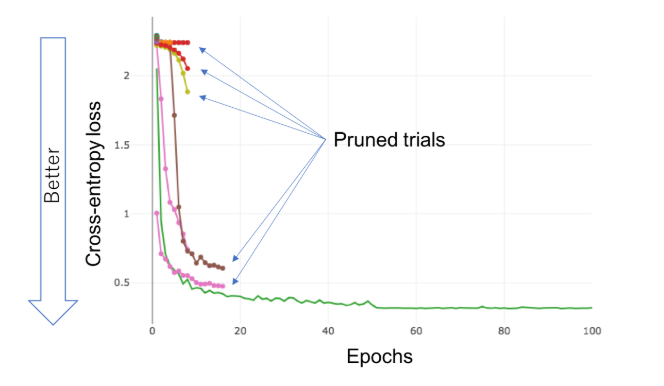

In [0]:
num_rounds = 10000
early_stop = 750
seed = 0
folds=8
cat_features = ['P0_species','P1_species','map']

In [0]:
# Referred https://github.com/pfnet/optuna/blob/master/examples/pruning/lightgbm_integration.py

def fit_lgbm_with_pruning(trial, train, val, devices=(-1,), seed=seed, cat_features=cat_features, num_rounds=num_rounds,early_stop=early_stop):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'auc'
    params = {
        #'num_leaves': trial.suggest_int('num_leaves', 16,1e+4),     # 16~128 정도
        'objective': 'binary',

        'max_depth': trial.suggest_int('max_depth', 5,27),  # 8,30
        #'learning_rate': trial.suggest_discrete_uniform('learning_rate', 1e-4, 0.05, 1e-4),   
        'learning_rate': trial.suggest_uniform('learning_rate',3e-3,3e-2),
        "boosting": "gbdt",#'dart','goss',

        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 30),   # 1~2     #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 40),   # 3~6   #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),

        #"bagging_freq": 5,
        "bagging_fraction": trial.suggest_discrete_uniform('bagging_fraction', 0.1, 0.9, 0.05), 
        "feature_fraction": trial.suggest_discrete_uniform('feature_fraction', 0.15, 0.65, 0.05),  # 0.1, 0.5
        #"bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.35, 0.35),
        #"feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 0.4),  

        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed
    early_stop = early_stop
    verbose_eval = 500  # 적합을 할 때, 과정을 보여줄 epoch 단위수 (500으로 하면 500:auc, 1000:auc, 1500:auc, ... 이렇게 보여줌)

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features
                          )
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features
                          )
    watchlist = [d_train, d_valid]

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc', valid_name='valid_1')    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration,cat_features=cat_features)
    print('#'*25,'이번 trial 중 가장 좋은 스코어는 다음과 같습니다.','#'*25)
    print('best_score', model.best_score)
    log = {'train/auc': model.best_score['training']['auc'],
           'valid/auc': model.best_score['valid_1']['auc']}
    return model, y_pred_valid, log

def objective_with_prune(trial: Trial, fast_check=True,seed=seed,folds=folds,cat_features=cat_features):
    """This method is completely same with previous `objective` method except calling `fit_lgbm_with_pruning`"""
    folds = folds
    seed = seed
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = x,y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('='*100)
    print('='*100)
    cat_features = cat_features
    print('cat_features : ', cat_features)

    models0 = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm_with_pruning(trial, train_data, valid_data, cat_features=cat_features,
                                                         num_rounds=num_rounds)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models0.append(model)
        gc.collect()
        valid_score += log["valid/auc"]
        if fast_check:
            break
    valid_score /= len(models0)
    return valid_score

In [0]:
#study = optuna.create_study(direction='maximize')   # auc니까 최대를 목표로
#study.optimize(objective_with_prune, n_trials=50)
#study.optimize(lambda trial: objective_with_prune(trial, arg0=1, arg1=2), n_trials=100)

study = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner(n_warmup_steps=20)) # 20차례는 적어도 지켜보고(warmup), 중앙값을 확인해 Prune 할지 결정
study.optimize(objective_with_prune, n_trials=120)

cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.756584	valid_1's auc: 0.702003
[1000]	training's auc: 0.802981	valid_1's auc: 0.719016
[1500]	training's auc: 0.837336	valid_1's auc: 0.727436
[2000]	training's auc: 0.86406	valid_1's auc: 0.730849
[2500]	training's auc: 0.885577	valid_1's auc: 0.73344
[3000]	training's auc: 0.90328	valid_1's auc: 0.73538
[3500]	training's auc: 0.917999	valid_1's auc: 0.736997
[4000]	training's auc: 0.930539	valid_1's auc: 0.737795
[4500]	training's auc: 0.941073	valid_1's auc: 0.738701
[5000]	training's auc: 0.949965	valid_1's auc: 0.739108
[5500]	training's auc: 0.957557	valid_1's auc: 0.739846
[6000]	training's auc: 0.963989	valid_1's auc: 0.740452
[6500]	training's auc: 0.969455	valid_1's auc: 0.740828
[7000]	training's auc: 0.974093	valid_1's auc: 0.741238
[7500]	training's auc: 0.977946	valid_1's auc: 0.741478
[8000]	traini

[I 2020-04-09 03:27:06,467] Finished trial#0 resulted in value: 0.742453175461129. Current best value is 0.742453175461129 with parameters: {'max_depth': 27, 'learning_rate': 0.005938949083885218, 'lambda_l1': 0.13710977985129436, 'lambda_l2': 7.504099753030751, 'bagging_fraction': 0.85, 'feature_fraction': 0.65}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.816879	valid_1's auc: 0.723596
[1000]	training's auc: 0.880104	valid_1's auc: 0.734393
[1500]	training's auc: 0.918828	valid_1's auc: 0.736536
[2000]	training's auc: 0.945311	valid_1's auc: 0.737809
[2500]	training's auc: 0.963248	valid_1's auc: 0.738381
[3000]	training's auc: 0.97542	valid_1's auc: 0.738775
[3500]	training's auc: 0.983527	valid_1's auc: 0.739017
[4000]	training's auc: 0.988904	valid_1's auc: 0.739366
[4500]	training's auc: 0.99258	valid_1's auc: 0.739491
[5000]	training's auc: 0.995021	valid_1's auc: 0.739354
Early stopping, best iteration is:
[4703]	training's auc: 0.993658	valid_1's auc: 0.739793
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9936578856630606}, 'valid_1': {'auc': 0.73979314855417

[I 2020-04-09 03:40:05,346] Finished trial#1 resulted in value: 0.7397931485541748. Current best value is 0.742453175461129 with parameters: {'max_depth': 27, 'learning_rate': 0.005938949083885218, 'lambda_l1': 0.13710977985129436, 'lambda_l2': 7.504099753030751, 'bagging_fraction': 0.85, 'feature_fraction': 0.65}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.772024	valid_1's auc: 0.708892
[1000]	training's auc: 0.819591	valid_1's auc: 0.723145
[1500]	training's auc: 0.854117	valid_1's auc: 0.729097
[2000]	training's auc: 0.879932	valid_1's auc: 0.731715
[2500]	training's auc: 0.900339	valid_1's auc: 0.733835
[3000]	training's auc: 0.916775	valid_1's auc: 0.735169
[3500]	training's auc: 0.930419	valid_1's auc: 0.735789
[4000]	training's auc: 0.941686	valid_1's auc: 0.736374
[4500]	training's auc: 0.951146	valid_1's auc: 0.736293
[5000]	training's auc: 0.959179	valid_1's auc: 0.736564
[5500]	training's auc: 0.965968	valid_1's auc: 0.736781
[6000]	training's auc: 0.971689	valid_1's auc: 0.736802
[6500]	training's auc: 0.976486	valid_1's auc: 0.737042
[7000]	training's auc: 0.980433	valid_1's auc: 0.736764
Early stopping, best iteration is:
[6514]	training's auc: 0.97660

[I 2020-04-09 03:56:55,851] Finished trial#2 resulted in value: 0.7370816121128737. Current best value is 0.742453175461129 with parameters: {'max_depth': 27, 'learning_rate': 0.005938949083885218, 'lambda_l1': 0.13710977985129436, 'lambda_l2': 7.504099753030751, 'bagging_fraction': 0.85, 'feature_fraction': 0.65}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.733464	valid_1's auc: 0.690625
[1000]	training's auc: 0.768052	valid_1's auc: 0.707953
[1500]	training's auc: 0.793037	valid_1's auc: 0.716709
[2000]	training's auc: 0.814018	valid_1's auc: 0.722553
[2500]	training's auc: 0.832135	valid_1's auc: 0.726118
[3000]	training's auc: 0.847892	valid_1's auc: 0.728989
[3500]	training's auc: 0.861619	valid_1's auc: 0.730942
[4000]	training's auc: 0.873625	valid_1's auc: 0.732357
[4500]	training's auc: 0.884341	valid_1's auc: 0.733415
[5000]	training's auc: 0.893742	valid_1's auc: 0.734269
[5500]	training's auc: 0.902423	valid_1's auc: 0.734979
[6000]	training's auc: 0.910313	valid_1's auc: 0.7355
[6500]	training's auc: 0.917341	valid_1's auc: 0.735924
[7000]	training's auc: 0.923883	valid_1's auc: 0.736328
[7500]	training's auc: 0.929875	valid_1's auc: 0.736685
[8000]	trai

[I 2020-04-09 04:23:24,856] Finished trial#3 resulted in value: 0.7374921634343304. Current best value is 0.742453175461129 with parameters: {'max_depth': 27, 'learning_rate': 0.005938949083885218, 'lambda_l1': 0.13710977985129436, 'lambda_l2': 7.504099753030751, 'bagging_fraction': 0.85, 'feature_fraction': 0.65}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.834769	valid_1's auc: 0.725601
[1000]	training's auc: 0.897132	valid_1's auc: 0.73273
[1500]	training's auc: 0.933936	valid_1's auc: 0.734142
[2000]	training's auc: 0.957857	valid_1's auc: 0.73493
[2500]	training's auc: 0.973239	valid_1's auc: 0.735286
[3000]	training's auc: 0.983133	valid_1's auc: 0.735118
Early stopping, best iteration is:
[2681]	training's auc: 0.977539	valid_1's auc: 0.735519
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.977538662001497}, 'valid_1': {'auc': 0.7355188738389175}})


[I 2020-04-09 04:32:51,722] Finished trial#4 resulted in value: 0.7355188738389175. Current best value is 0.742453175461129 with parameters: {'max_depth': 27, 'learning_rate': 0.005938949083885218, 'lambda_l1': 0.13710977985129436, 'lambda_l2': 7.504099753030751, 'bagging_fraction': 0.85, 'feature_fraction': 0.65}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.850377	valid_1's auc: 0.730231
[1000]	training's auc: 0.915256	valid_1's auc: 0.738563
[1500]	training's auc: 0.949702	valid_1's auc: 0.7407
[2000]	training's auc: 0.970204	valid_1's auc: 0.742334
[2500]	training's auc: 0.982444	valid_1's auc: 0.742474
[3000]	training's auc: 0.989653	valid_1's auc: 0.741911
Early stopping, best iteration is:
[2525]	training's auc: 0.98287	valid_1's auc: 0.742658
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9828700842428278}, 'valid_1': {'auc': 0.742658027523713}})


[I 2020-04-09 04:40:55,295] Finished trial#5 resulted in value: 0.742658027523713. Current best value is 0.742658027523713 with parameters: {'max_depth': 19, 'learning_rate': 0.026765850901725806, 'lambda_l1': 5.593548105975087, 'lambda_l2': 11.906892778355115, 'bagging_fraction': 0.9, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 04:41:13,209] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 04:41:29,699] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 04:41:46,263] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 04:42:03,194] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 04:42:20,020] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.837419	valid_1's auc: 0.727543
[1000]	training's auc: 0.902238	valid_1's auc: 0.737654
[1500]	training's auc: 0.939077	valid_1's auc: 0.739464
[2000]	training's auc: 0.961354	valid_1's auc: 0.74158
[2500]	training's auc: 0.975453	valid_1's auc: 0.742217
[3000]	training's auc: 0.984324	valid_1's auc: 0.742831
[3500]	training's auc: 0.990173	valid_1's auc: 0.742804
Early stopping, best iteration is:
[2808]	training's auc: 0.981439	valid_1's auc: 0.743086
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9814385562673207}, 'valid_1': {'auc': 0.7430856922101996}})


[I 2020-04-09 04:51:13,558] Finished trial#11 resulted in value: 0.7430856922101996. Current best value is 0.7430856922101996 with parameters: {'max_depth': 18, 'learning_rate': 0.02098175611615633, 'lambda_l1': 0.15398947854464984, 'lambda_l2': 10.547638061402242, 'bagging_fraction': 0.1, 'feature_fraction': 0.15}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.859448	valid_1's auc: 0.733628
[1000]	training's auc: 0.924051	valid_1's auc: 0.739613
[1500]	training's auc: 0.957339	valid_1's auc: 0.740663
[2000]	training's auc: 0.975888	valid_1's auc: 0.74097
[2500]	training's auc: 0.986545	valid_1's auc: 0.740824
Early stopping, best iteration is:
[2147]	training's auc: 0.979498	valid_1's auc: 0.741339
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9794976057573076}, 'valid_1': {'auc': 0.7413392817808744}})


[I 2020-04-09 04:58:42,872] Finished trial#12 resulted in value: 0.7413392817808744. Current best value is 0.7430856922101996 with parameters: {'max_depth': 18, 'learning_rate': 0.02098175611615633, 'lambda_l1': 0.15398947854464984, 'lambda_l2': 10.547638061402242, 'bagging_fraction': 0.1, 'feature_fraction': 0.15}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 04:59:00,350] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.847444	valid_1's auc: 0.728746
[1000]	training's auc: 0.915867	valid_1's auc: 0.736651
[1500]	training's auc: 0.95298	valid_1's auc: 0.740335
[2000]	training's auc: 0.973942	valid_1's auc: 0.741726
[2500]	training's auc: 0.985558	valid_1's auc: 0.742248
[3000]	training's auc: 0.992157	valid_1's auc: 0.742268
Early stopping, best iteration is:
[2580]	training's auc: 0.986943	valid_1's auc: 0.742589
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9869431410251827}, 'valid_1': {'auc': 0.7425888963065631}})


[I 2020-04-09 05:07:12,845] Finished trial#14 resulted in value: 0.7425888963065631. Current best value is 0.7430856922101996 with parameters: {'max_depth': 18, 'learning_rate': 0.02098175611615633, 'lambda_l1': 0.15398947854464984, 'lambda_l2': 10.547638061402242, 'bagging_fraction': 0.1, 'feature_fraction': 0.15}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:07:31,527] Setting status of trial#15 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:07:48,651] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:08:05,874] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:08:23,027] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.881013	valid_1's auc: 0.730991
[1000]	training's auc: 0.946923	valid_1's auc: 0.735754
[1500]	training's auc: 0.976157	valid_1's auc: 0.737115
[2000]	training's auc: 0.989374	valid_1's auc: 0.739558
[2500]	training's auc: 0.995404	valid_1's auc: 0.739637
[3000]	training's auc: 0.997955	valid_1's auc: 0.740821
[3500]	training's auc: 0.999054	valid_1's auc: 0.740271
Early stopping, best iteration is:
[3020]	training's auc: 0.998005	valid_1's auc: 0.740985
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9980053048680277}, 'valid_1': {'auc': 0.740985492610754}})


[I 2020-04-09 05:17:24,267] Finished trial#19 resulted in value: 0.740985492610754. Current best value is 0.7430856922101996 with parameters: {'max_depth': 18, 'learning_rate': 0.02098175611615633, 'lambda_l1': 0.15398947854464984, 'lambda_l2': 10.547638061402242, 'bagging_fraction': 0.1, 'feature_fraction': 0.15}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:17:42,396] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.854749	valid_1's auc: 0.7302
[1000]	training's auc: 0.922174	valid_1's auc: 0.738001
[1500]	training's auc: 0.957273	valid_1's auc: 0.739945
[2000]	training's auc: 0.97697	valid_1's auc: 0.740745
[2500]	training's auc: 0.9878	valid_1's auc: 0.741571
[3000]	training's auc: 0.99354	valid_1's auc: 0.742318
[3500]	training's auc: 0.996512	valid_1's auc: 0.741925
[4000]	training's auc: 0.998128	valid_1's auc: 0.74261
[4500]	training's auc: 0.999056	valid_1's auc: 0.74323
[5000]	training's auc: 0.999492	valid_1's auc: 0.742947
Early stopping, best iteration is:
[4510]	training's auc: 0.999071	valid_1's auc: 0.743377
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9990714081391071}, 'valid_1': {'auc': 0.7433766194157057}})


[I 2020-04-09 05:31:22,454] Finished trial#21 resulted in value: 0.7433766194157057. Current best value is 0.7433766194157057 with parameters: {'max_depth': 20, 'learning_rate': 0.023327663493263436, 'lambda_l1': 2.314752330900321, 'lambda_l2': 1.4123558514542687, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.852724	valid_1's auc: 0.731403
[1000]	training's auc: 0.919485	valid_1's auc: 0.738196
[1500]	training's auc: 0.95448	valid_1's auc: 0.739954
[2000]	training's auc: 0.973917	valid_1's auc: 0.73979
Early stopping, best iteration is:
[1575]	training's auc: 0.958205	valid_1's auc: 0.740395
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9582051095590204}, 'valid_1': {'auc': 0.740394996797598}})


[I 2020-04-09 05:38:02,794] Finished trial#22 resulted in value: 0.740394996797598. Current best value is 0.7433766194157057 with parameters: {'max_depth': 20, 'learning_rate': 0.023327663493263436, 'lambda_l1': 2.314752330900321, 'lambda_l2': 1.4123558514542687, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:38:21,167] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:38:38,637] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:38:55,977] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:39:14,256] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:39:31,653] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:39:49,216] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.848411	valid_1's auc: 0.729512
[1000]	training's auc: 0.914934	valid_1's auc: 0.73738
[1500]	training's auc: 0.950427	valid_1's auc: 0.738964
[2000]	training's auc: 0.970946	valid_1's auc: 0.739647
[2500]	training's auc: 0.982984	valid_1's auc: 0.741092
[3000]	training's auc: 0.989987	valid_1's auc: 0.741097
Early stopping, best iteration is:
[2719]	training's auc: 0.986537	valid_1's auc: 0.741609
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9865371727388523}, 'valid_1': {'auc': 0.74160869020065}})


[I 2020-04-09 05:49:46,158] Finished trial#29 resulted in value: 0.74160869020065. Current best value is 0.7433766194157057 with parameters: {'max_depth': 20, 'learning_rate': 0.023327663493263436, 'lambda_l1': 2.314752330900321, 'lambda_l2': 1.4123558514542687, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:50:04,890] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:50:22,484] Setting status of trial#31 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:50:40,917] Setting status of trial#32 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:50:58,414] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:51:16,099] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 05:51:33,429] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.855452	valid_1's auc: 0.729837
[1000]	training's auc: 0.921187	valid_1's auc: 0.737594
[1500]	training's auc: 0.955881	valid_1's auc: 0.739783
[2000]	training's auc: 0.975656	valid_1's auc: 0.740904
[2500]	training's auc: 0.986656	valid_1's auc: 0.740261
[3000]	training's auc: 0.992545	valid_1's auc: 0.740637
Early stopping, best iteration is:
[2301]	training's auc: 0.983037	valid_1's auc: 0.741222
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.983037085351978}, 'valid_1': {'auc': 0.7412220298145318}})


[I 2020-04-09 06:00:33,804] Finished trial#36 resulted in value: 0.7412220298145318. Current best value is 0.7433766194157057 with parameters: {'max_depth': 20, 'learning_rate': 0.023327663493263436, 'lambda_l1': 2.314752330900321, 'lambda_l2': 1.4123558514542687, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:00:51,863] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:01:10,175] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:01:27,639] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:01:45,400] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:02:03,077] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:02:21,087] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:02:38,999] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:02:56,648] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:03:14,218] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:03:31,854] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:03:49,460] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:04:06,424] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:04:24,060] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:05:00,100] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at iteration 112.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:05:18,050] Setting status of trial#51 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.860188	valid_1's auc: 0.731553
[1000]	training's auc: 0.925828	valid_1's auc: 0.738458
[1500]	training's auc: 0.959502	valid_1's auc: 0.740501
[2000]	training's auc: 0.977925	valid_1's auc: 0.740999
[2500]	training's auc: 0.987951	valid_1's auc: 0.742291
[3000]	training's auc: 0.993507	valid_1's auc: 0.742534
[3500]	training's auc: 0.996507	valid_1's auc: 0.741829
Early stopping, best iteration is:
[2873]	training's auc: 0.992339	valid_1's auc: 0.742767
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9923394101775302}, 'valid_1': {'auc': 0.7427668075271696}})


[I 2020-04-09 06:16:21,522] Finished trial#52 resulted in value: 0.7427668075271696. Current best value is 0.7433766194157057 with parameters: {'max_depth': 20, 'learning_rate': 0.023327663493263436, 'lambda_l1': 2.314752330900321, 'lambda_l2': 1.4123558514542687, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.864411	valid_1's auc: 0.732984
[1000]	training's auc: 0.928583	valid_1's auc: 0.738764
[1500]	training's auc: 0.960902	valid_1's auc: 0.741189
[2000]	training's auc: 0.978678	valid_1's auc: 0.7416
[2500]	training's auc: 0.988222	valid_1's auc: 0.742374
[3000]	training's auc: 0.993556	valid_1's auc: 0.742304
[3500]	training's auc: 0.996469	valid_1's auc: 0.742902
[4000]	training's auc: 0.998025	valid_1's auc: 0.743127
[4500]	training's auc: 0.998922	valid_1's auc: 0.742869
Early stopping, best iteration is:
[4111]	training's auc: 0.998256	valid_1's auc: 0.743319
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9982556267375982}, 'valid_1': {'auc': 0.7433193489465961}})


[I 2020-04-09 06:31:48,275] Finished trial#53 resulted in value: 0.7433193489465961. Current best value is 0.7433766194157057 with parameters: {'max_depth': 20, 'learning_rate': 0.023327663493263436, 'lambda_l1': 2.314752330900321, 'lambda_l2': 1.4123558514542687, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.864838	valid_1's auc: 0.73434
[1000]	training's auc: 0.929694	valid_1's auc: 0.739856
[1500]	training's auc: 0.961858	valid_1's auc: 0.74025
[2000]	training's auc: 0.97945	valid_1's auc: 0.740624
[2500]	training's auc: 0.988977	valid_1's auc: 0.741163
[3000]	training's auc: 0.994137	valid_1's auc: 0.741145
Early stopping, best iteration is:
[2311]	training's auc: 0.986103	valid_1's auc: 0.741509
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9861031254461574}, 'valid_1': {'auc': 0.7415090599171104}})


[I 2020-04-09 06:42:08,032] Finished trial#54 resulted in value: 0.7415090599171104. Current best value is 0.7433766194157057 with parameters: {'max_depth': 20, 'learning_rate': 0.023327663493263436, 'lambda_l1': 2.314752330900321, 'lambda_l2': 1.4123558514542687, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:42:27,291] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:42:46,468] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:43:04,808] Setting status of trial#57 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:43:23,030] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:43:40,996] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:43:59,354] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:44:17,467] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 06:44:35,532] Setting status of trial#62 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.855999	valid_1's auc: 0.731125
[1000]	training's auc: 0.922876	valid_1's auc: 0.738022
[1500]	training's auc: 0.957906	valid_1's auc: 0.741147
[2000]	training's auc: 0.976704	valid_1's auc: 0.740955
Early stopping, best iteration is:
[1690]	training's auc: 0.96616	valid_1's auc: 0.741604
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9661598979399864}, 'valid_1': {'auc': 0.7416039459014337}})


[I 2020-04-09 06:52:44,499] Finished trial#63 resulted in value: 0.7416039459014337. Current best value is 0.7433766194157057 with parameters: {'max_depth': 20, 'learning_rate': 0.023327663493263436, 'lambda_l1': 2.314752330900321, 'lambda_l2': 1.4123558514542687, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.874835	valid_1's auc: 0.733679
[1000]	training's auc: 0.941044	valid_1's auc: 0.739837
[1500]	training's auc: 0.972505	valid_1's auc: 0.742145
[2000]	training's auc: 0.987036	valid_1's auc: 0.743059
[2500]	training's auc: 0.994013	valid_1's auc: 0.743295
[3000]	training's auc: 0.9973	valid_1's auc: 0.743246
Early stopping, best iteration is:
[2600]	training's auc: 0.994945	valid_1's auc: 0.743572
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9949453259114122}, 'valid_1': {'auc': 0.7435724911976306}})


[I 2020-04-09 07:03:40,201] Finished trial#64 resulted in value: 0.7435724911976306. Current best value is 0.7435724911976306 with parameters: {'max_depth': 18, 'learning_rate': 0.028793211891335775, 'lambda_l1': 2.1740995772848573, 'lambda_l2': 1.3638812122179473, 'bagging_fraction': 0.1, 'feature_fraction': 0.2}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.878662	valid_1's auc: 0.733784
[1000]	training's auc: 0.944764	valid_1's auc: 0.739091
[1500]	training's auc: 0.974738	valid_1's auc: 0.742537
[2000]	training's auc: 0.988581	valid_1's auc: 0.742111
[2500]	training's auc: 0.994795	valid_1's auc: 0.743618
[3000]	training's auc: 0.997709	valid_1's auc: 0.744314
[3500]	training's auc: 0.998979	valid_1's auc: 0.744504
[4000]	training's auc: 0.999557	valid_1's auc: 0.744459
Early stopping, best iteration is:
[3307]	training's auc: 0.99859	valid_1's auc: 0.744697
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9985900369503266}, 'valid_1': {'auc': 0.7446967206726061}})


[I 2020-04-09 07:17:15,772] Finished trial#65 resulted in value: 0.7446967206726061. Current best value is 0.7446967206726061 with parameters: {'max_depth': 18, 'learning_rate': 0.029931224733443788, 'lambda_l1': 2.258917869782862, 'lambda_l2': 2.285162719746363, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.879788	valid_1's auc: 0.735013
[1000]	training's auc: 0.946068	valid_1's auc: 0.742035
[1500]	training's auc: 0.975698	valid_1's auc: 0.744193
[2000]	training's auc: 0.989309	valid_1's auc: 0.744693
[2500]	training's auc: 0.995236	valid_1's auc: 0.744022
Early stopping, best iteration is:
[2055]	training's auc: 0.990326	valid_1's auc: 0.744954
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9903257329319092}, 'valid_1': {'auc': 0.7449539294658258}})


[I 2020-04-09 07:27:10,789] Finished trial#66 resulted in value: 0.7449539294658258. Current best value is 0.7449539294658258 with parameters: {'max_depth': 18, 'learning_rate': 0.029808215292347336, 'lambda_l1': 2.1771923346414135, 'lambda_l2': 1.8305682767682614, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.876874	valid_1's auc: 0.734076
[1000]	training's auc: 0.943794	valid_1's auc: 0.737915


[I 2020-04-09 07:31:23,890] Setting status of trial#67 as TrialState.PRUNED. Trial was pruned at iteration 1065.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.86616	valid_1's auc: 0.73253
[1000]	training's auc: 0.932319	valid_1's auc: 0.739267
[1500]	training's auc: 0.965006	valid_1's auc: 0.740651
[2000]	training's auc: 0.981941	valid_1's auc: 0.741972
[2500]	training's auc: 0.990797	valid_1's auc: 0.742406
[3000]	training's auc: 0.995306	valid_1's auc: 0.741492
Early stopping, best iteration is:
[2516]	training's auc: 0.99098	valid_1's auc: 0.742572
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9909803496191386}, 'valid_1': {'auc': 0.7425724606985642}})


[I 2020-04-09 07:42:56,933] Finished trial#68 resulted in value: 0.7425724606985642. Current best value is 0.7449539294658258 with parameters: {'max_depth': 18, 'learning_rate': 0.029808215292347336, 'lambda_l1': 2.1771923346414135, 'lambda_l2': 1.8305682767682614, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 07:43:16,539] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.872425	valid_1's auc: 0.732052


[I 2020-04-09 07:46:22,043] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at iteration 724.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.880603	valid_1's auc: 0.731333


[I 2020-04-09 07:48:55,111] Setting status of trial#71 as TrialState.PRUNED. Trial was pruned at iteration 566.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.887034	valid_1's auc: 0.733461


[I 2020-04-09 07:52:59,732] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at iteration 893.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 07:53:22,061] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at iteration 26.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 07:53:40,922] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.864182	valid_1's auc: 0.731758
[1000]	training's auc: 0.930186	valid_1's auc: 0.738679


[I 2020-04-09 07:58:52,203] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at iteration 1248.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 07:59:13,897] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at iteration 26.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.883098	valid_1's auc: 0.734425
[1000]	training's auc: 0.949411	valid_1's auc: 0.738922
[1500]	training's auc: 0.978076	valid_1's auc: 0.741443
[2000]	training's auc: 0.990359	valid_1's auc: 0.742896
[2500]	training's auc: 0.996028	valid_1's auc: 0.742716
[3000]	training's auc: 0.998353	valid_1's auc: 0.742651
Early stopping, best iteration is:
[2354]	training's auc: 0.99487	valid_1's auc: 0.743193
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9948698918907428}, 'valid_1': {'auc': 0.7431931166995943}})


[I 2020-04-09 08:10:42,236] Finished trial#77 resulted in value: 0.7431931166995943. Current best value is 0.7449539294658258 with parameters: {'max_depth': 18, 'learning_rate': 0.029808215292347336, 'lambda_l1': 2.1771923346414135, 'lambda_l2': 1.8305682767682614, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.880932	valid_1's auc: 0.733329


[I 2020-04-09 08:14:10,191] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at iteration 771.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:14:31,763] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at iteration 26.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:14:53,136] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at iteration 26.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.884214	valid_1's auc: 0.73271


[I 2020-04-09 08:18:13,045] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at iteration 658.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.869663	valid_1's auc: 0.733118


[I 2020-04-09 08:21:50,017] Setting status of trial#82 as TrialState.PRUNED. Trial was pruned at iteration 789.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.881706	valid_1's auc: 0.733167


[I 2020-04-09 08:25:28,600] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at iteration 810.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:25:48,166] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:26:08,089] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:26:27,674] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at iteration 22.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:26:47,622] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:27:07,596] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:27:28,305] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:27:49,756] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at iteration 26.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:28:09,732] Setting status of trial#91 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:28:34,596] Setting status of trial#92 as TrialState.PRUNED. Trial was pruned at iteration 42.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:28:54,785] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:29:14,807] Setting status of trial#94 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:29:56,807] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at iteration 107.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.858361	valid_1's auc: 0.731448


[I 2020-04-09 08:32:45,171] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at iteration 571.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:33:04,840] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:33:23,754] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:33:42,880] Setting status of trial#99 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 08:34:22,096] Setting status of trial#100 as TrialState.PRUNED. Trial was pruned at iteration 96.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.868926	valid_1's auc: 0.734478
[1000]	training's auc: 0.93492	valid_1's auc: 0.738656


[I 2020-04-09 08:39:54,177] Setting status of trial#101 as TrialState.PRUNED. Trial was pruned at iteration 1286.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.874833	valid_1's auc: 0.733067
[1000]	training's auc: 0.941472	valid_1's auc: 0.738577


[I 2020-04-09 08:45:10,234] Setting status of trial#102 as TrialState.PRUNED. Trial was pruned at iteration 1234.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.875717	valid_1's auc: 0.732111


[I 2020-04-09 08:48:28,649] Setting status of trial#103 as TrialState.PRUNED. Trial was pruned at iteration 691.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.8731	valid_1's auc: 0.732805
[1000]	training's auc: 0.940788	valid_1's auc: 0.74013
[1500]	training's auc: 0.972201	valid_1's auc: 0.741315
[2000]	training's auc: 0.9869	valid_1's auc: 0.74247
[2500]	training's auc: 0.994098	valid_1's auc: 0.743522
[3000]	training's auc: 0.997311	valid_1's auc: 0.744819
[3500]	training's auc: 0.998813	valid_1's auc: 0.745419
[4000]	training's auc: 0.99945	valid_1's auc: 0.745383
[4500]	training's auc: 0.999758	valid_1's auc: 0.745281
[5000]	training's auc: 0.999887	valid_1's auc: 0.746431
[5500]	training's auc: 0.999946	valid_1's auc: 0.746217
Early stopping, best iteration is:
[4982]	training's auc: 0.999886	valid_1's auc: 0.746526
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.999

[I 2020-04-09 09:10:42,489] Finished trial#104 resulted in value: 0.7465256480204412. Current best value is 0.7465256480204412 with parameters: {'max_depth': 25, 'learning_rate': 0.026813415309555645, 'lambda_l1': 1.1024606492004492, 'lambda_l2': 1.831117696954427, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:11:10,553] Setting status of trial#105 as TrialState.PRUNED. Trial was pruned at iteration 42.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:11:30,016] Setting status of trial#106 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:12:07,732] Setting status of trial#107 as TrialState.PRUNED. Trial was pruned at iteration 86.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:14:44,073] Setting status of trial#108 as TrialState.PRUNED. Trial was pruned at iteration 477.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:15:05,616] Setting status of trial#109 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:17:35,968] Setting status of trial#110 as TrialState.PRUNED. Trial was pruned at iteration 441.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.869796	valid_1's auc: 0.732361


[I 2020-04-09 09:21:27,778] Setting status of trial#111 as TrialState.PRUNED. Trial was pruned at iteration 790.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:21:49,904] Setting status of trial#112 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:22:10,589] Setting status of trial#113 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:22:31,356] Setting status of trial#114 as TrialState.PRUNED. Trial was pruned at iteration 22.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.871837	valid_1's auc: 0.735065
[1000]	training's auc: 0.937889	valid_1's auc: 0.740432
[1500]	training's auc: 0.969267	valid_1's auc: 0.740994
[2000]	training's auc: 0.984859	valid_1's auc: 0.741889
[2500]	training's auc: 0.992659	valid_1's auc: 0.742458
[3000]	training's auc: 0.996471	valid_1's auc: 0.74289
[3500]	training's auc: 0.998348	valid_1's auc: 0.743229
[4000]	training's auc: 0.999179	valid_1's auc: 0.74315
Early stopping, best iteration is:
[3465]	training's auc: 0.998267	valid_1's auc: 0.743442
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9982670471240065}, 'valid_1': {'auc': 0.7434421924084434}})


[I 2020-04-09 09:39:51,424] Finished trial#115 resulted in value: 0.7434421924084434. Current best value is 0.7465256480204412 with parameters: {'max_depth': 25, 'learning_rate': 0.026813415309555645, 'lambda_l1': 1.1024606492004492, 'lambda_l2': 1.831117696954427, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:40:12,571] Setting status of trial#116 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:40:33,240] Setting status of trial#117 as TrialState.PRUNED. Trial was pruned at iteration 24.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.880834	valid_1's auc: 0.733367


[I 2020-04-09 09:44:15,995] Setting status of trial#118 as TrialState.PRUNED. Trial was pruned at iteration 731.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-09 09:44:36,255] Setting status of trial#119 as TrialState.PRUNED. Trial was pruned at iteration 21.


## 1. lr & max_depth & row_samp & col_samp 튜닝

In [0]:
# 8 Fold
# n_feature = 5948
# Check study history to get best hyperparameters
print('Best trial: score {}, params {}'.format(study.best_value, study.best_params))

#trials_df = study.trials_dataframe()
#trials_df


Best trial: score 0.7452304543344257, params {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}


In [0]:
# 8 Fold
# n_feature = 4948
# Check study history to get best hyperparameters
print('Best trial: score {}, params {}'.format(study.best_value, study.best_params))

#trials_df = study.trials_dataframe()
#trials_df


Best trial: score 0.7465256480204412, params {'max_depth': 25, 'learning_rate': 0.026813415309555645, 'lambda_l1': 1.1024606492004492, 'lambda_l2': 1.831117696954427, 'bagging_fraction': 0.1, 'feature_fraction': 0.25}


In [0]:
### Visualize study history to analayze the hyperparams-performance relationship

optuna.visualization.plot_optimization_history(study)   #Optimization history
#optuna.visualization.plot_intermediate_values(study)   #Visualize pruning history
#optuna.visualization.plot_slice(study)    #Visualize plot slice
#optuna.visualization.plot_contour(study)    #Visualize plot contour (변수들 pairwise plot => 두 모수의 상호작용효과 확인)
#optuna.visualization.plot_parallel_coordinate(study)   #Visualize parallel_coordinate

#출처 : https://github.com/pfnet/optuna/tree/master/examples/visualization


In [0]:
### Visualize study history to analayze the hyperparams-performance relationship

#optuna.visualization.plot_optimization_history(study)   #Optimization history
optuna.visualization.plot_intermediate_values(study)   #Visualize pruning history
#optuna.visualization.plot_slice(study)    #Visualize plot slice
#optuna.visualization.plot_contour(study)    #Visualize plot contour (변수들 pairwise plot => 두 모수의 상호작용효과 확인)
#optuna.visualization.plot_parallel_coordinate(study)   #Visualize parallel_coordinate

#출처 : https://github.com/pfnet/optuna/tree/master/examples/visualization


Output hidden; open in https://colab.research.google.com to view.

# 최적화된 모수의 모델 적합시키고 변수중요도 Plot 확인, pred값 생성

In [0]:
print(x.shape)

(38872, 4948)


In [0]:

def objective(trial: Trial, fast_check=True,  return_info=False,seed=seed,folds=folds,cat_features = cat_features):
    folds = folds
    seed = seed
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = x,y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()

    cat_features = cat_features
    print('cat_features', cat_features)

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data, cat_features=cat_features,
                                            num_rounds=num_rounds)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/auc"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

def fit_lgbm(trial, train, val, devices=(-1,), seed=seed, num_rounds=num_rounds,early_stop=early_stop,cat_features = cat_features):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'auc'
    params = {
        #'num_leaves': trial.suggest_int('num_leaves', 8, 1024),
        'objective': 'binary',
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-10, 0.1),
        "boosting": "gbdt",#'dart','goss'
        #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 50), 
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 50),
        #"bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0, 1),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0, 1),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = early_stop
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/auc': model.best_score['training']['auc'],
           'valid/auc': model.best_score['valid_1']['auc']}
    return model, y_pred_valid, log

####################################### 모델 불러오기 ###################################
valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, return_info=True   )

#best_params = {'max_depth': 28, 'learning_rate': 0.025670843196156163, 'lambda_l1': 1.4356189976639242, 'lambda_l2': 20.693747661310503, 'bagging_fraction': 0.35, 'feature_fraction': 0.30000000000000004}
#valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(best_params), fast_check=False, return_info=True   )


cat_features ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.8731	valid_1's auc: 0.732805
[1000]	training's auc: 0.940788	valid_1's auc: 0.74013
[1500]	training's auc: 0.972201	valid_1's auc: 0.741315
[2000]	training's auc: 0.9869	valid_1's auc: 0.74247
[2500]	training's auc: 0.994098	valid_1's auc: 0.743522
[3000]	training's auc: 0.997311	valid_1's auc: 0.744819
[3500]	training's auc: 0.998813	valid_1's auc: 0.745419
[4000]	training's auc: 0.99945	valid_1's auc: 0.745383
[4500]	training's auc: 0.999758	valid_1's auc: 0.745281
[5000]	training's auc: 0.999887	valid_1's auc: 0.746431
[5500]	training's auc: 0.999946	valid_1's auc: 0.746217
Early stopping, best iteration is:
[4982]	training's auc: 0.999886	valid_1's auc: 0.746526
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9998855160719448}, 'valid_1': {'auc': 0.7465256480204412}})
train 34013 valid 4859
trainin

In [0]:
import matplotlib.pyplot as plt

################################ 변수중요도 플랏 ############################
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=x.columns,
                                 columns=['importance']).iloc[:200,:].sort_values('importance')
    fig, ax = plt.subplots(figsize=(16, 70))
    importance_df.plot.barh(ax=ax)
    fig.show()
plot_feature_importance(models0[1])
#plot_feature_importance(models1[1])
#plot_feature_importance(models2[1])

## 제출 파일 생성

In [0]:
print(no_missing_train.drop(bad_features,axis=1).drop(rf_bad_features,axis=1).copy().shape)


(38872, 4949)


In [0]:
test_Ability_Raw.index = no_missing_test.index
test_Ability.index = no_missing_test.index
test_Selection_Raw.index =  no_missing_test.index
test_Selection.index = no_missing_test.index
test_Right_Raw.index =  no_missing_test.index
test_Right.index = no_missing_test.index

In [0]:

test_X = pd.concat([no_missing_test,test_Ability_Raw,test_Ability,
                    test_Selection_Raw,test_Selection,
                    test_Right_Raw, test_Right],axis=1).drop(bad_features,axis=1).drop(rf_bad_features,axis=1).copy()

print(test_X.shape)
preds = []
for model in models0:
    pred = model.predict(test_X)#predict_proba    [:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

submission = pd.read_csv('sample_submission.csv', index_col=0)
submission['winner'] = submission['winner'] + pred
submission.to_csv('제출/모델링40_8FOLD_permutation후에_RF변수선택_Raw_Ability Selection Right.csv', encoding='utf8')
submission.head()

(16787, 4948)


,winner
game_id,
38872,0.426830
38873,0.684984
38874,0.397438
38875,0.126371
38876,0.635475


## 제출파일 중에 좋은것들 평균내보기

In [0]:
data1 = pd.read_csv('제출/모델링30_2_Ability_Selection_합친후_데이터전체에permutation_eta줄임.csv', encoding = 'utf8')
data2 = pd.read_csv('제출/모델링30_시간_2분_Ability_Selection_합친후_데이터전체에permutation.csv', encoding = 'utf8')
data3 = pd.read_csv('제출/모델링22_2_permutation1번만_시간구간없이단어임베딩.csv', encoding = 'utf8')
data4 = pd.read_csv('제출/모델링21_시간_2분_permutation후에_Ability_Select_Right.csv', encoding = 'utf8')

mean_pred = (data1['winner']+data2['winner']+data3['winner']+data4['winner'])/4

data5 = pd.read_csv('sample_submission.csv', index_col=0)
data5['winner'] = data5['winner'] + mean_pred
data5.to_csv('제출/21과22_2와30과30_2평균내기.csv',encoding='utf8',index=False)
data5.head()